In [1]:
#pip install py7zr

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import numpy as np
import py7zr
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from joblib import dump, load

import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams['figure.figsize'] = [15.0, 10.0]
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'medium'

In [4]:
interpolated_data = pd.read_csv('interpolated_data_tl1.csv', low_memory = False)

In [5]:
df = interpolated_data.copy()
df['time'] = pd.to_datetime(df['time'])
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051201 entries, 0 to 1051200
Columns: 154 entries, time to Скважина ЛА-506: Давление забойное, barg
dtypes: datetime64[ns](1), float64(119), object(34)
memory usage: 1.2+ GB


time Платформа: Температура окружающей среды, degC  \
0 2022-08-01 00:00:00                                      13.56105   
1 2022-08-01 00:00:30                                      13.57446   
2 2022-08-01 00:01:00                                      13.58788   
3 2022-08-01 00:01:30                                      13.60461   
4 2022-08-01 00:02:00                                      13.62154   
5 2022-08-01 00:02:30                                      13.63938   
6 2022-08-01 00:03:00                                      13.65722   
7 2022-08-01 00:03:30                                      13.67319   
8 2022-08-01 00:04:00                                      13.68915   
9 2022-08-01 00:04:30                                      13.70383   

   ТЛ1 Сепаратор : Расход по газу, kSm3/h  \
0                                1050.821   
1                                1050.176   
2                                1050.351   
3                                1050.908   
4                                1046.780   
5                                1046.071   
6                                1047.964   
7                                1049.856   
8                                1051.749   
9                                1047.011   

  ТЛ1 Сепаратор : Расход по конденсату, Sm3/h  \
0                                    37.12975   
1                                    37.56005   
2                                    37.03209   
3                                    37.16535   
4                                    36.90152   
5                                    33.61278   
6                                    28.98388   
7                                    26.82405   
8                                    26.03109   
9                                    25.30749   

   ТЛ1 Сепаратор : Расход по воде  , m3/h  \
0                                0.188499   
1                                0.188499   
2                                0.188499   
3                                2.345471   
4                                3.685060   
5                                3.615524   
6                                3.570450   
7                                3.559652   
8                                3.617787   
9                                1.394205   

   ТЛ1 Сепаратор : Температура на выходе газа, degC  \
0                                          59.42110   
1                                          59.42216   
2                                          59.42322   
3                                          59.42428   
4                                          59.42533   
5                                          59.42640   
6                                          59.42745   
7                                          59.42851   
8                                          59.42957   
9                                          59.43063   

   ТЛ1 Сепаратор : Температура на выходе конденсата, degC  \
0                                           59.61190        
1                                           59.61227        
2                                           59.61264        
3                                           59.61302        
4                                           59.61340        
5                                           59.61377        
6                                           59.61415        
7                                           59.61452        
8                                           59.61489        
9                                           59.61527        

   ТЛ1 Сепаратор : Давление на выходе газа, barg  \
0                                       94.68169   
1                                       94.68456   
2                                       94.68744   
3                                       94.69032   
4                                       94.69319   
5                                       94.69607   
6                                       94.69894   
7        

=========================================================================================================================

# Функции для предобработки

In [6]:
# Функция для поиска слов в строковом объекте

def word_search(x, pattern):
    list_words = pattern.findall(x)
    if len(list_words) != 0:
        return True
    else:
        return False

In [7]:
# Функция для подсчёта количества слов в колонке датафрейма

def count_words(column, pattern):
    count = 0
    for x in column:
        list_words = pattern.findall(x)
        if len(list_words) != 0:
            count += 1
    return print(count)

In [8]:
# Функция для поиска и извлечения слов в колонке датафрейма

def extract_words(column, pattern):
    index_values = {}
    for i, x in enumerate(column):
        list_words = pattern.findall(x)
        if len(list_words) != 0:
            word = list_words[0]
            index_values[i] = word
    return index_values

In [9]:
# Функция для преобразования в столбцах датафрейма строкового типа данных в числовой и замены нечисловых значений 
# на числа методом линейной интерполяции

def feature_processing(df, pattern):
    for column in df.columns[1:]:
        df[column] = df[column].apply(lambda x: float(str(x)) if len(pattern.findall(str(x))) == 0 else None)
        df[column] = df[column].interpolate(method = 'linear')

In [10]:
# Валидация и визуализация предсказанных значений расхода по газу на всех скважинах

def validation_visualize(dataframe, list_columns, model):
    
    dataframe['Суммарный предсказанный расход по газу, ksm3/h'] = np.zeros(len(dataframe))
    dataframe_modified = dataframe.drop(['time', 'Суммарный предсказанный расход по газу, ksm3/h'], axis = 1)
    
    list_convs = []
    
    for i in range(10, dataframe_modified.shape[1], 13):
        dataframe_test = pd.DataFrame(np.hstack([dataframe_modified.iloc[:, :10], dataframe_modified.iloc[:, i:i + 13]]), 
                                      columns = list_columns)
        X_array_test = dataframe_test.drop('Скважина: Расход по газу Вентури, ksm3/h', axis = 1)
        y_array_test = dataframe_test['Скважина: Расход по газу Вентури, ksm3/h'].values
        
        # Нормализация
        X_array_test = scaler.transform(X_array_test)
        
        # Предсказание
        y_array_pred = model.predict(X_array_test)
        dataframe['Суммарный предсказанный расход по газу, ksm3/h'] += y_array_pred
        
        convergence = round((1 - abs(y_array_test - y_array_pred).mean()/y_array_test.mean())*100, 2)
        list_convs.append(convergence)
        
        plt.figure(figsize = (15, 10))
        plt.plot(dataframe['time'].values, y_array_test)
        plt.plot(dataframe['time'].values, y_array_pred)
        #plt.xlim([datetime.strptime('2023-06-05 12:00:00', '%Y-%m-%d %H:%M:%S'), \
        #          datetime.strptime('2023-06-05 15:00:00', '%Y-%m-%d %H:%M:%S')])
        plt.ylim(-50, 250)
        plt.xticks(rotation = 45)
        plt.legend(['Расход по газу Вентури, ksm3/h', 'Предсказанный расход по газу, ksm3/h'])
        plt.title(dataframe_modified.columns[i][:17] + ' расход по газу, ksm3/h; ' + f'Сходимость: {convergence} %; ' + \
                  f'MAE = {round(mean_absolute_error(y_array_test, y_array_pred), 2)}')
        plt.xlabel('Дата')
        plt.ylabel(dataframe_modified.columns[i][:17] + ' расход по газу, ksm3/h')
        plt.grid()
        
    convergence_sum = round((1 - abs(dataframe.iloc[:, 2].values - dataframe['Суммарный предсказанный расход по газу, ksm3/h'].values).mean()/dataframe.iloc[:, 2].values.mean())*100, 2)
        
    # Вывод графиков суммарного предсказанного расхода по газу и расхода по газу на сепараторе
    plt.figure(figsize = (15, 10))
    plt.plot(dataframe['time'].values, dataframe.iloc[:, 2])
    plt.plot(dataframe['time'].values, dataframe['Суммарный предсказанный расход по газу, ksm3/h'])
    plt.xticks(rotation = 45)
    plt.legend([dataframe.columns[2], 'Суммарный предсказанный расход по газу, ksm3/h'])
    plt.title('Суммарный расход по газу, ksm3/h; ' + f'Сходимость: {convergence_sum} %')
    plt.xlabel('Дата')
    plt.ylabel('Расход по газу, ksm3/h')
    plt.grid()
        
    print('Средняя сходимость по всем скважинам: ', round(sum(list_convs)/len(list_convs), 2), '%')
    print('Минимальная сходимость: ', round(min(list_convs), 2), '%')

=========================================================================================================================

In [11]:
# Время работы кода 7 мин.

pattern = re.compile('[A-Za-z]+')
feature_processing(df, pattern)

## Подготовка данных для обучения моделей

### Подготовка обучающих данных

Соединим данные вертикально по каждой скважине.

In [12]:
df_modified_train = \
df[(df['time'] > datetime.strptime('2022-08-01 00:00:00', '%Y-%m-%d %H:%M:%S')) & \
   (df['time'] < datetime.strptime('2023-04-30 23:59:30', '%Y-%m-%d %H:%M:%S'))].drop(['time', 
                                                                                       #'ТЛ1: Суммарный расход по газу Вентури, kSm3/h', 
                                                                                       #'Дельта расхода по газу, kSm3/h'
                                                                                      ], axis = 1)

df_modified_train.shape

(786238, 153)

In [13]:
list_columns = ['Платформа: Температура окружающей среды, degC', 'ТЛ Сепаратор : Расход по газу, kSm3/h', 
                'ТЛ Сепаратор : Расход по конденсату, Sm3/h', 'ТЛ Сепаратор : Расход по воде  , m3/h', 
                'ТЛ Сепаратор : Температура на выходе газа, degC', 'ТЛ Сепаратор : Температура на выходе конденсата, degC', 
                'ТЛ Сепаратор : Давление на выходе газа, barg', 'ТЛ Сепаратор : Давление на выходе конденсата, barg', 
                'ТЛ Манифольд : Давление, barg', 'ТЛ Манифольд : Температура, degC', 
                'Скважина: Процент открытия штуцера, %', 'Скважина: Расход по газу Вентури, ksm3/h', 
                'Скважина: Расход по конденсату Вентури, sm3/h', 'Скважина: Расход по воде Вентури, sm3/h', 
                'Скважина: Температура на трубке Вентури, degC', 'Скважина: Перепад давления на трубке Вентури газ, mbar', 
                'Скважина: Перепад давления на трубке Вентури конденсат, mbar', 'Скважина: Перепад давления на трубке Вентури вода, mbar', 
                'Скважина: Давление на трубке Вентури, bara', 'Скважина: Температура на выкидной линии, degC', 
                'Скважина: Давление над буферной задвижкой ФА, barg', 'Скважина: Температура забойная, degC', 
                'Скважина: Давление забойное, barg']

len(list_columns)

23

In [14]:
separator = df_modified_train.iloc[:, :10]
for i in range(9):
    separator = np.vstack([separator, df_modified_train.iloc[:, :10]])

wells = np.vstack([df_modified_train.iloc[:, 10:23], df_modified_train.iloc[:, 23:36], df_modified_train.iloc[:, 36:49], 
                   df_modified_train.iloc[:, 49:62], df_modified_train.iloc[:, 62:75], df_modified_train.iloc[:, 75:88], 
                   df_modified_train.iloc[:, 88:101], df_modified_train.iloc[:, 101:114], df_modified_train.iloc[:, 114:127], 
                   df_modified_train.iloc[:, 127:140]])

df_train = pd.DataFrame(np.hstack([separator, wells]), columns = list_columns)
df_train.columns

Index(['Платформа: Температура окружающей среды, degC',
       'ТЛ Сепаратор : Расход по газу, kSm3/h',
       'ТЛ Сепаратор : Расход по конденсату, Sm3/h',
       'ТЛ Сепаратор : Расход по воде  , m3/h',
       'ТЛ Сепаратор : Температура на выходе газа, degC',
       'ТЛ Сепаратор : Температура на выходе конденсата, degC',
       'ТЛ Сепаратор : Давление на выходе газа, barg',
       'ТЛ Сепаратор : Давление на выходе конденсата, barg',
       'ТЛ Манифольд : Давление, barg', 'ТЛ Манифольд : Температура, degC',
       'Скважина: Процент открытия штуцера, %',
       'Скважина: Расход по газу Вентури, ksm3/h',
       'Скважина: Расход по конденсату Вентури, sm3/h',
       'Скважина: Расход по воде Вентури, sm3/h',
       'Скважина: Температура на трубке Вентури, degC',
       'Скважина: Перепад давления на трубке Вентури газ, mbar',
       'Скважина: Перепад давления на трубке Вентури конденсат, mbar',
       'Скважина: Перепад давления на трубке Вентури вода, mbar',
       'Скважина: 

In [15]:
X_train = df_train.drop('Скважина: Расход по газу Вентури, ksm3/h', axis = 1)
y_train = df_train['Скважина: Расход по газу Вентури, ksm3/h'].values

In [16]:
# Нормализация обучающих данных

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Обучение

### Подготовка тестовых данных за период с 2023-05-01 по 2023-08-01

In [17]:
df_modified_test = \
df[(df['time'] > datetime.strptime('2023-05-01 00:00:00', '%Y-%m-%d %H:%M:%S')) & \
   (df['time'] < datetime.strptime('2023-08-01 00:00:00', '%Y-%m-%d %H:%M:%S'))]

df_modified_test.shape

(264959, 154)

### Подготовка тестовых данных за период с 2023-08-01 по 2023-08-02

In [18]:
df4 = pd.read_csv('interpolated_data_4.csv', low_memory = False)
df4['time'] = pd.to_datetime(df4['time'])
feature_processing(df4, pattern)

In [19]:
df4_test = \
df4[(df4['time'] > datetime.strptime('2023-08-02 00:00:00', '%Y-%m-%d %H:%M:%S')) & \
    (df4['time'] < datetime.strptime('2023-08-03 00:00:00', '%Y-%m-%d %H:%M:%S'))]

df4_test.shape

(2879, 141)

# XGBoost

In [20]:
import xgboost as xgb

In [21]:
xb = xgb.XGBRegressor(n_estimators = 1000, colsample_bytree = 0.2, max_depth = 10, learning_rate = 0.01, 
                      objective = 'reg:squarederror', alpha = 1, n_jobs = -1)

Оценка алгоритма XGBoost производится на данных в период с 2023-08-01 по 2023-10-01.

1. **Baseline**: параметры - **n_estimators = 1000, colsample_bytree = 0.2, max_depth = 20, learning_rate = 0.01, objective = 'reg:squarederror', alpha = 1, n_jobs = -1**; средняя сходимость по скважинам - **92.14 %**.
2. **learning_rate = 0.005**: параметры - **n_estimators = 1000, colsample_bytree = 0.2, max_depth = 20, learning_rate = 0.005, objective = 'reg:squarederror', alpha = 1, n_jobs = -1**; средняя сходимость по скважинам - **91.82 %**.
3. **max_depth = 15, learning_rate = 0.01**: параметры - **n_estimators = 1000, colsample_bytree = 0.2, max_depth = 15, learning_rate = 0.01, objective = 'reg:squarederror', alpha = 1, n_jobs = -1**; средняя сходимость по скважинам - **93.21 %**.
-----------------------------------------------------------------------------------------------------------------------------
4. **max_depth = 10**: параметры - **n_estimators = 1000, colsample_bytree = 0.2, max_depth = 10, learning_rate = 0.01, objective = 'reg:squarederror', alpha = 1, n_jobs = -1**; средняя сходимость по скважинам - **96.04 %**; минимальная сходимость - **91.79 %**
-----------------------------------------------------------------------------------------------------------------------------
5. **n_estimators = 2000, learning_rate = 0.005**: параметры - **n_estimators = 2000, colsample_bytree = 0.2, max_depth = 10, learning_rate = 0.005, objective = 'reg:squarederror', alpha = 1, n_jobs = -1**; средняя сходимость по скважинам - **95.93 %**.
6. **n_estimators = 3000**: параметры - **n_estimators = 3000, colsample_bytree = 0.2, max_depth = 10, learning_rate = 0.005, objective = 'reg:squarederror', alpha = 1, n_jobs = -1**; средняя сходимость по скважинам - **96.04 %**.
7. **n_estimators = 6000**: параметры - **n_estimators = 6000, colsample_bytree = 0.2, max_depth = 10, learning_rate = 0.001, objective = 'reg:squarederror', alpha = 1, n_jobs = -1**; средняя сходимость по скважинам - **94.79 %**.
8. **n_estimators = 10000**: параметры - **n_estimators = 10000, colsample_bytree = 0.2, max_depth = 10, learning_rate = 0.001, objective = 'reg:squarederror', alpha = 1, n_jobs = -1**; средняя сходимость по скважинам - **95.19 %**.
9. **n_estimators = 500, learning_rate = 0.01**: параметры - **n_estimators = 500, colsample_bytree = 0.2, max_depth = 10, learning_rate = 0.01, objective = 'reg:squarederror', alpha = 1, n_jobs = -1**; средняя сходимость по скважинам - **95.66 %**.

In [22]:
#xb.fit(X_train, y_train)

In [23]:
#dump(xb, 'xb22.joblib')

## Валидация данных и оценка модели

In [24]:
xb = load('xb22.joblib')

**Данные за период с 2023-05-01 по 2023-08-01**

Средняя сходимость по всем скважинам:  95.3 %
Минимальная сходимость:  78.43 %


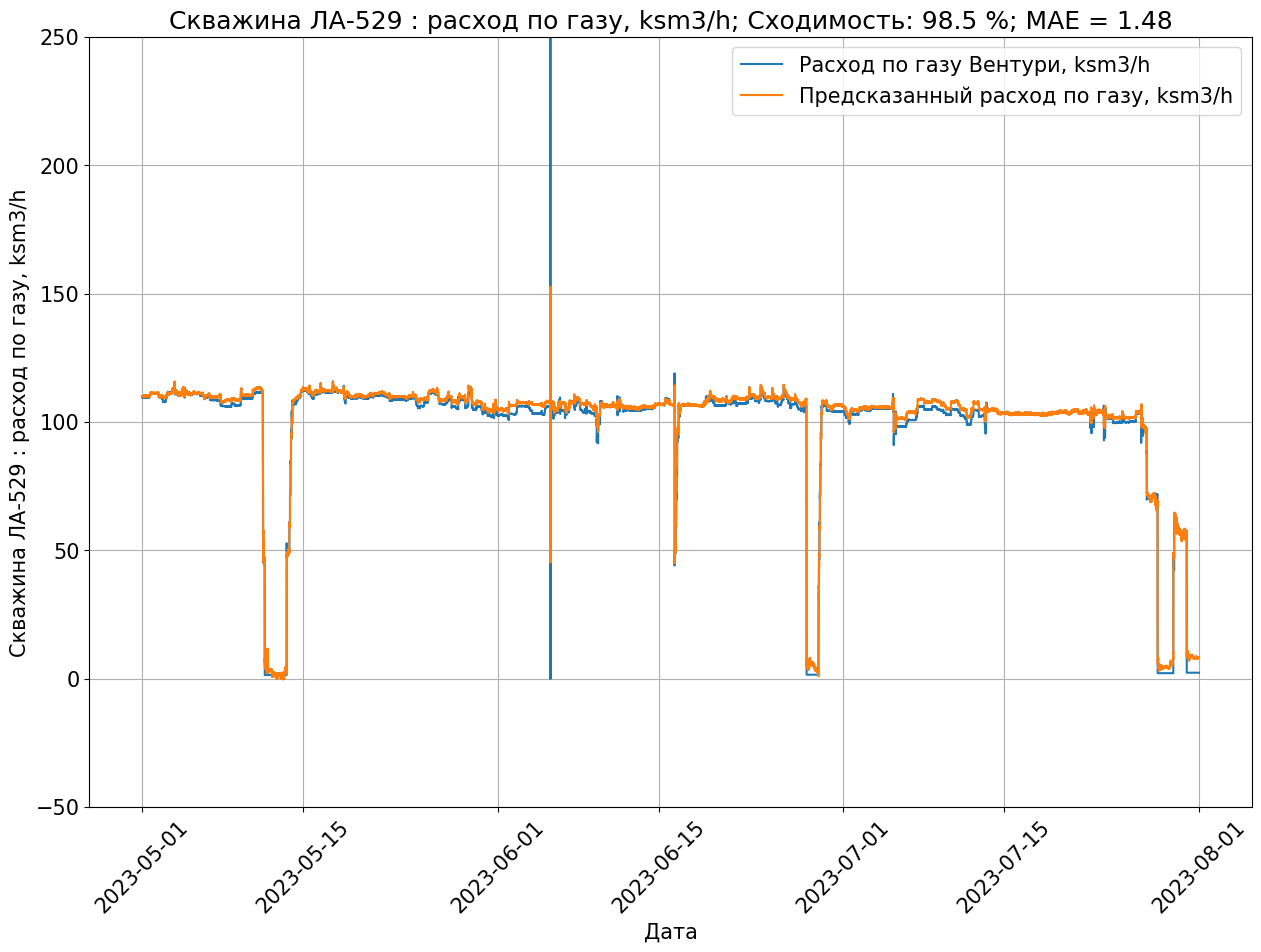

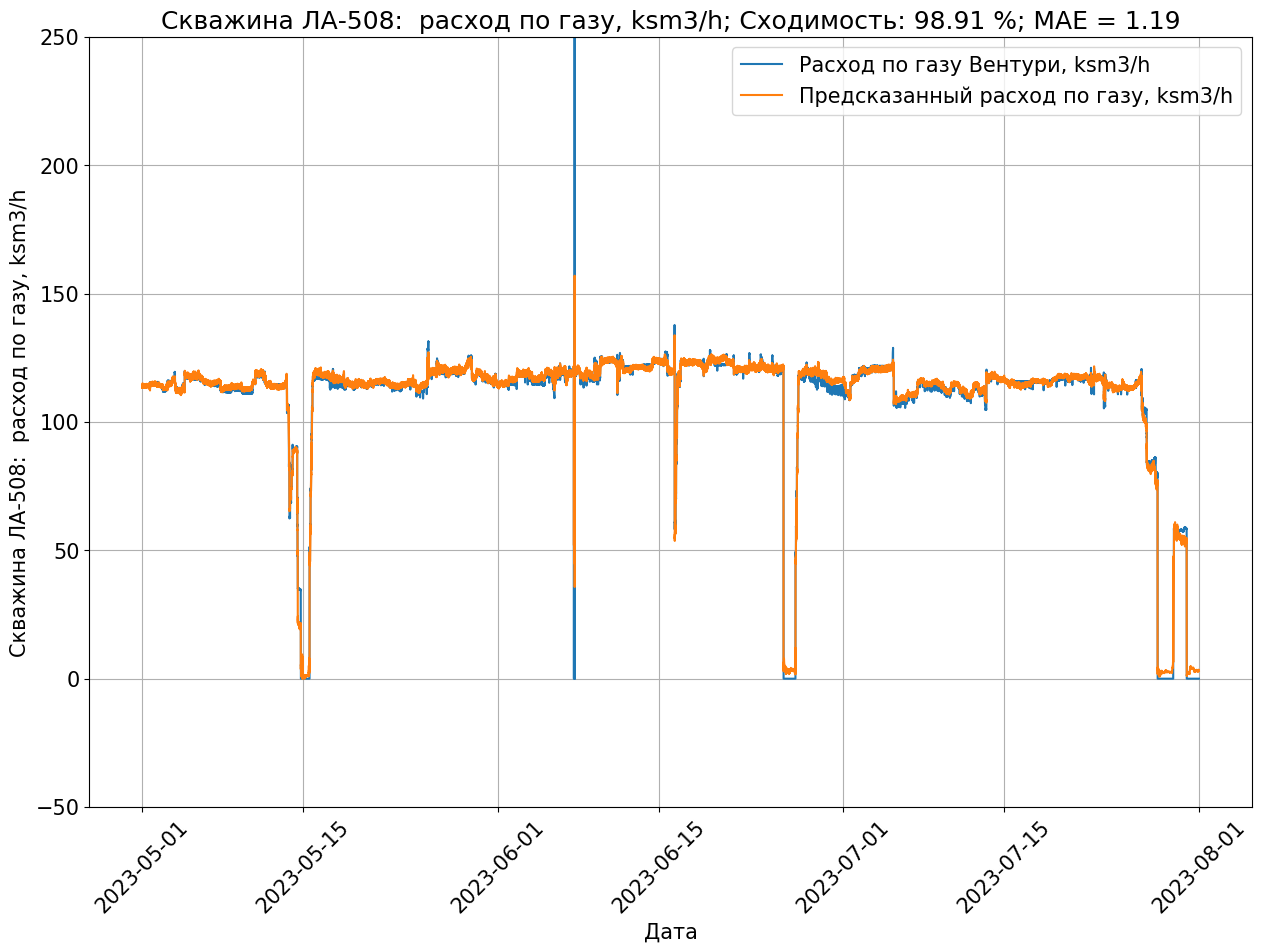

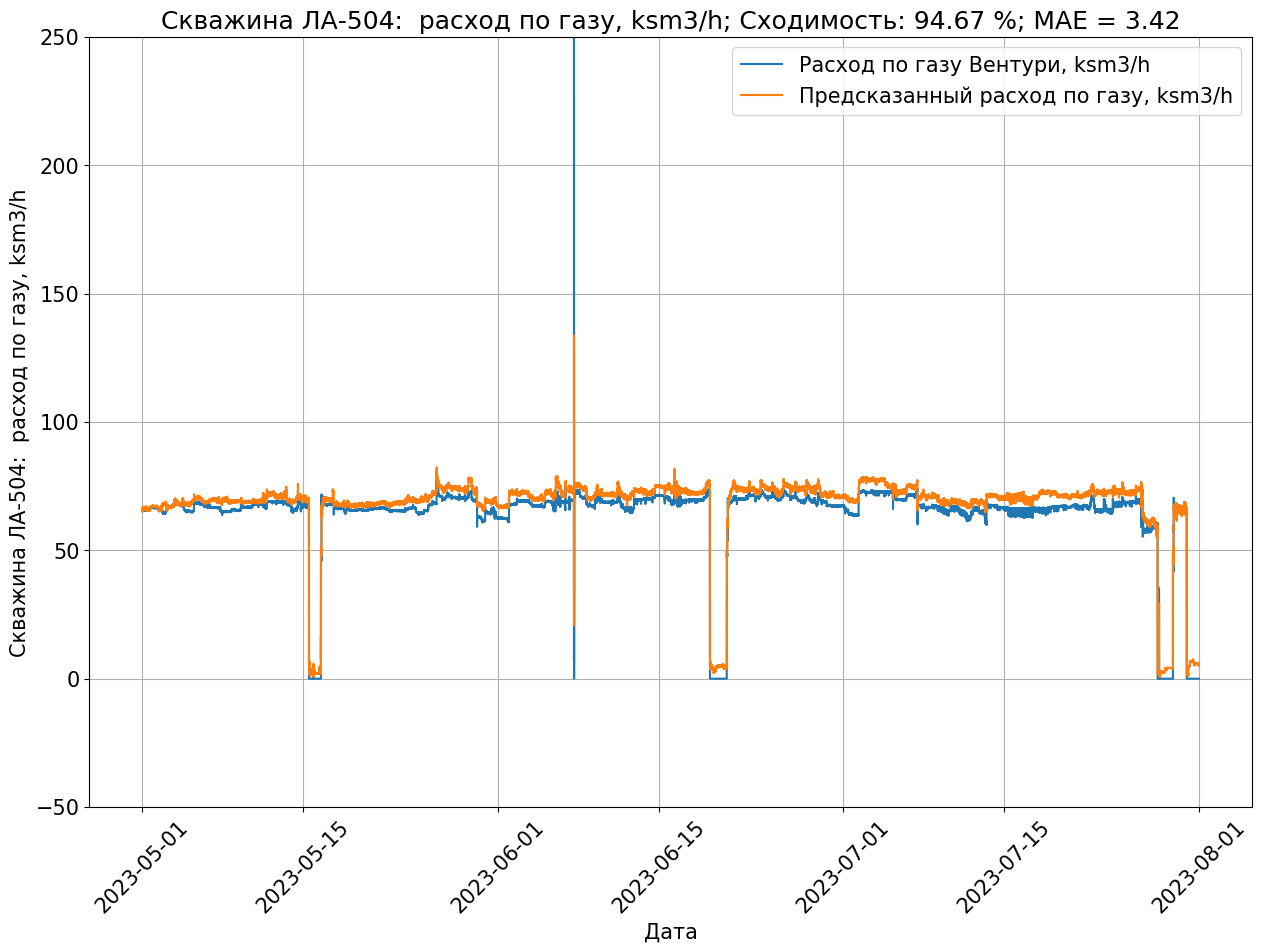

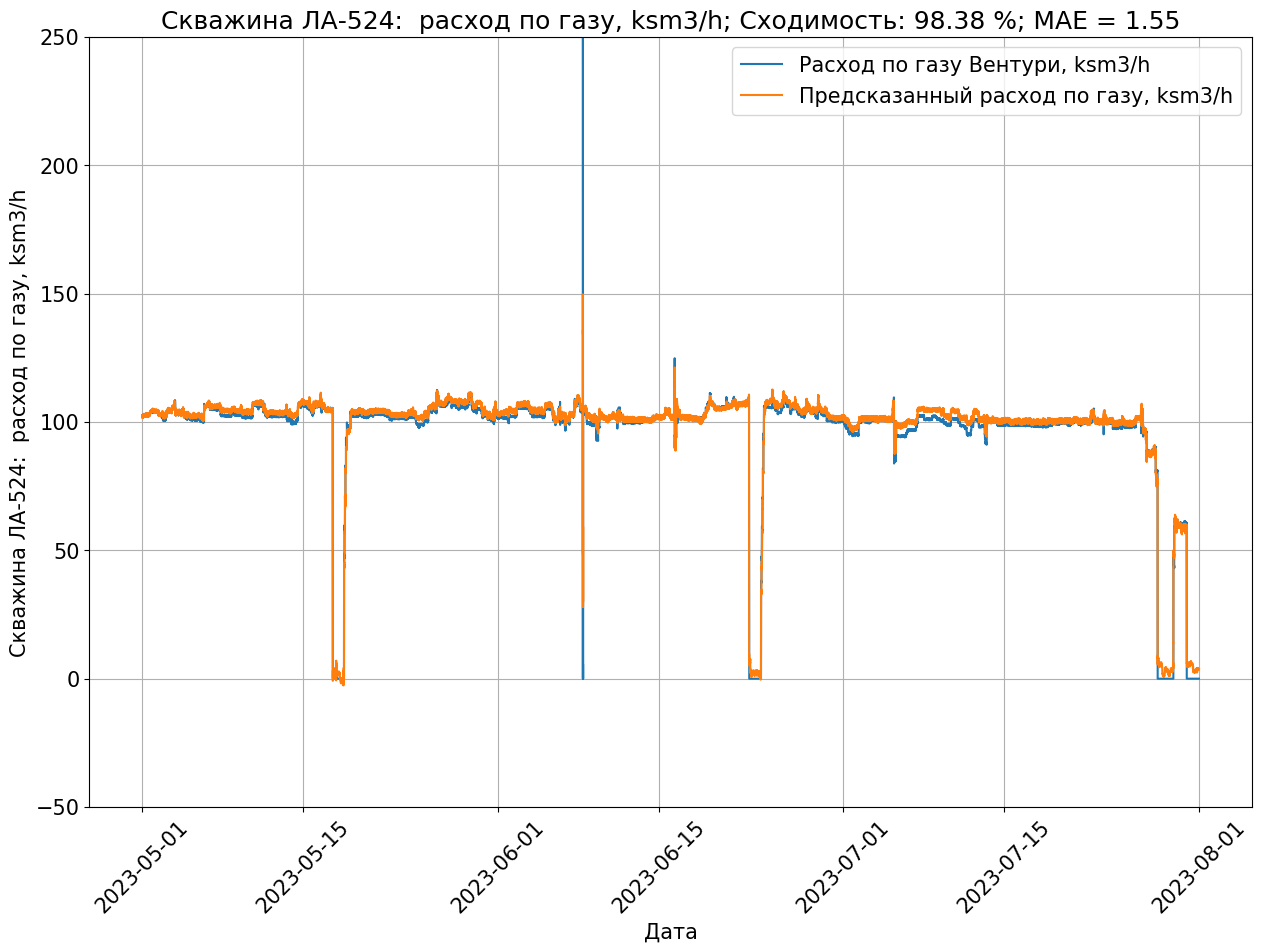

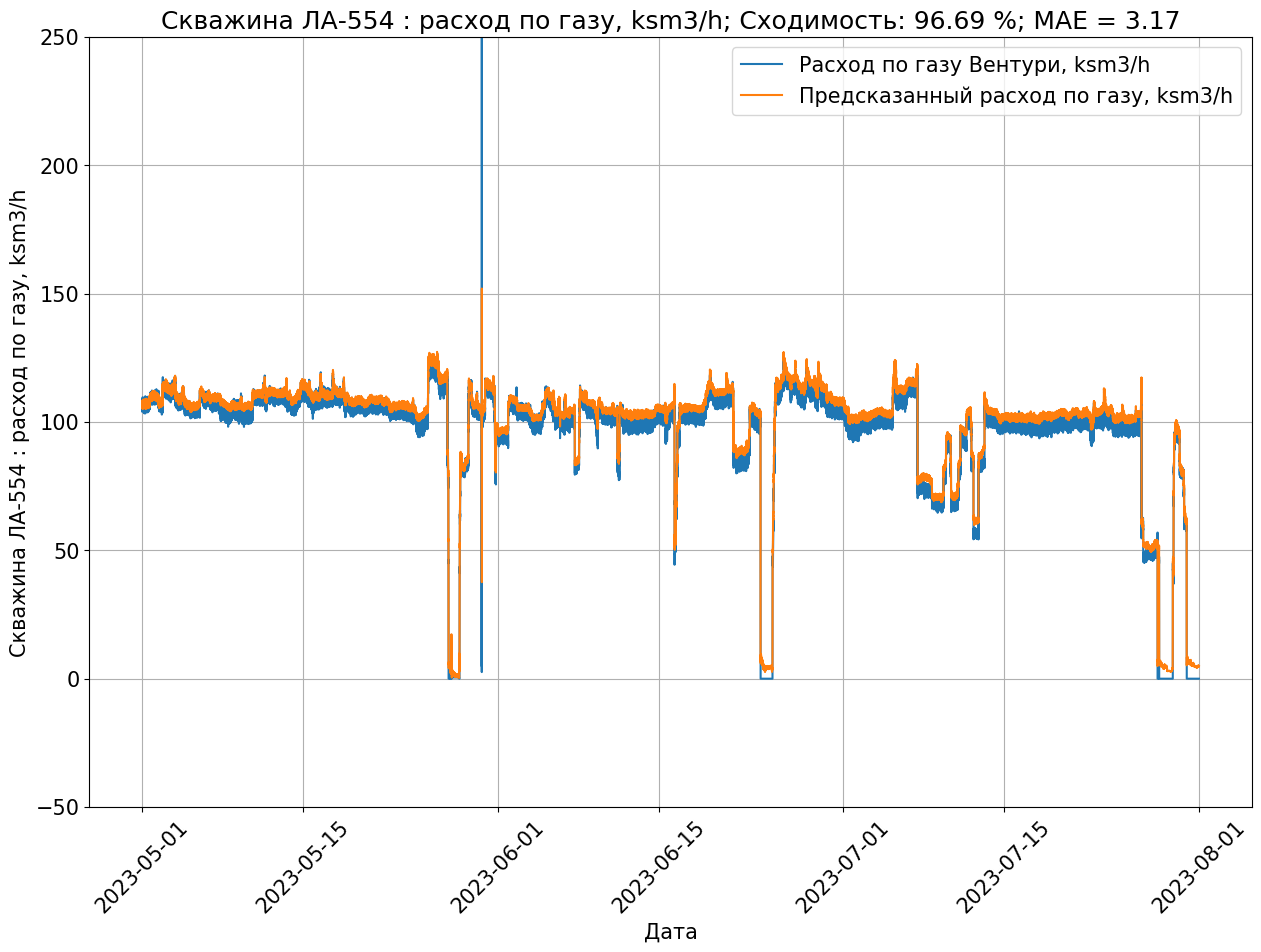

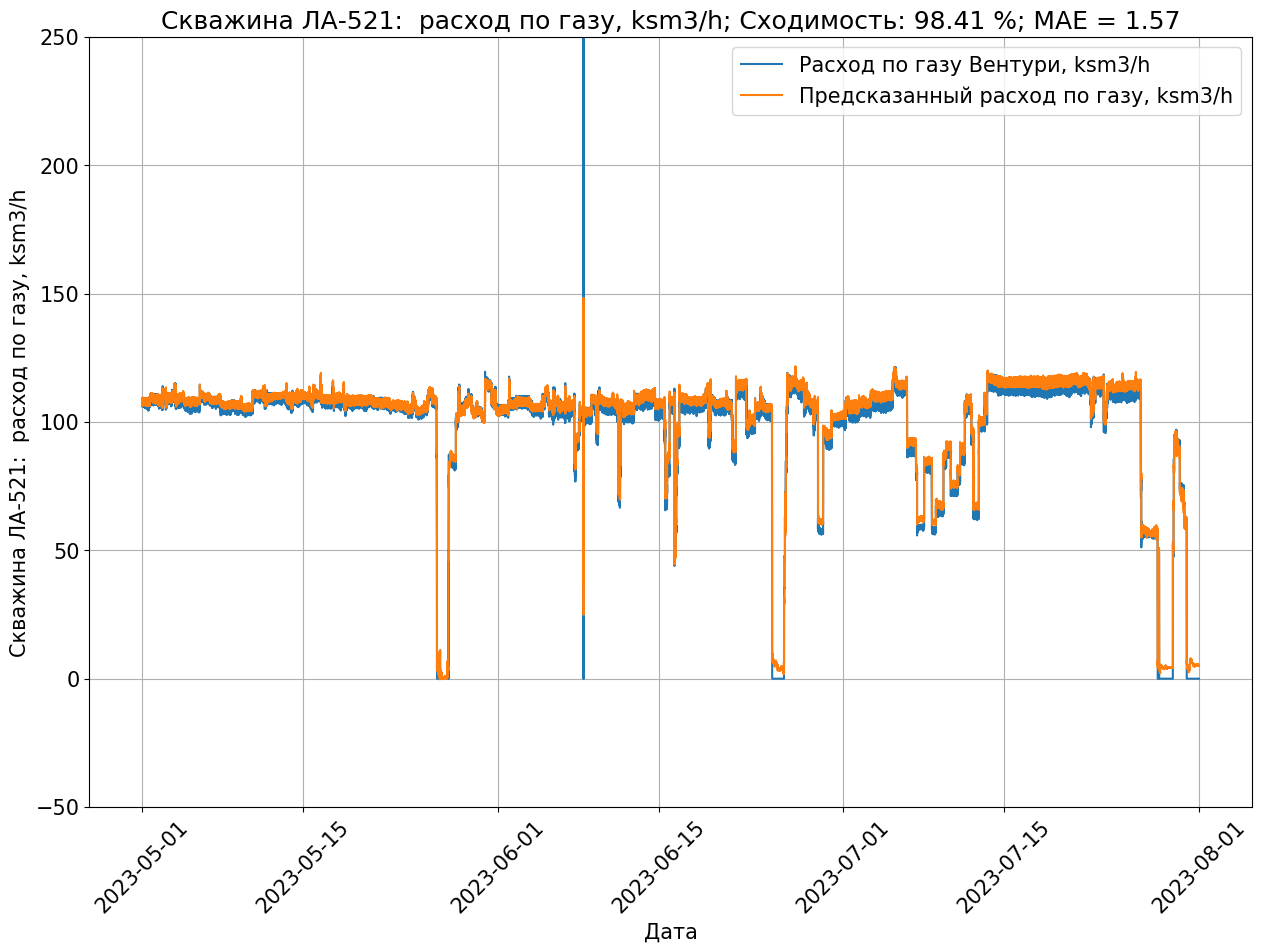

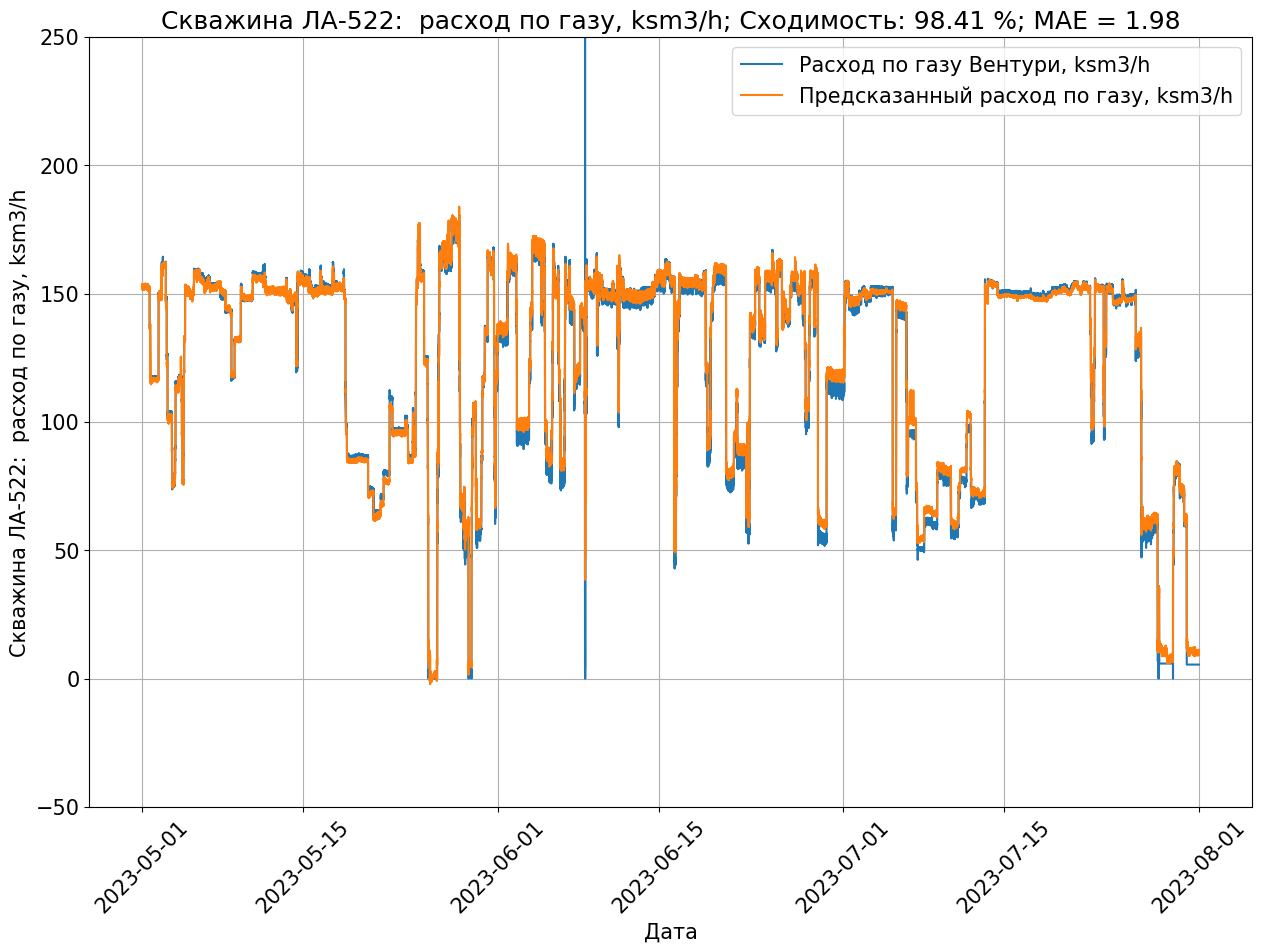

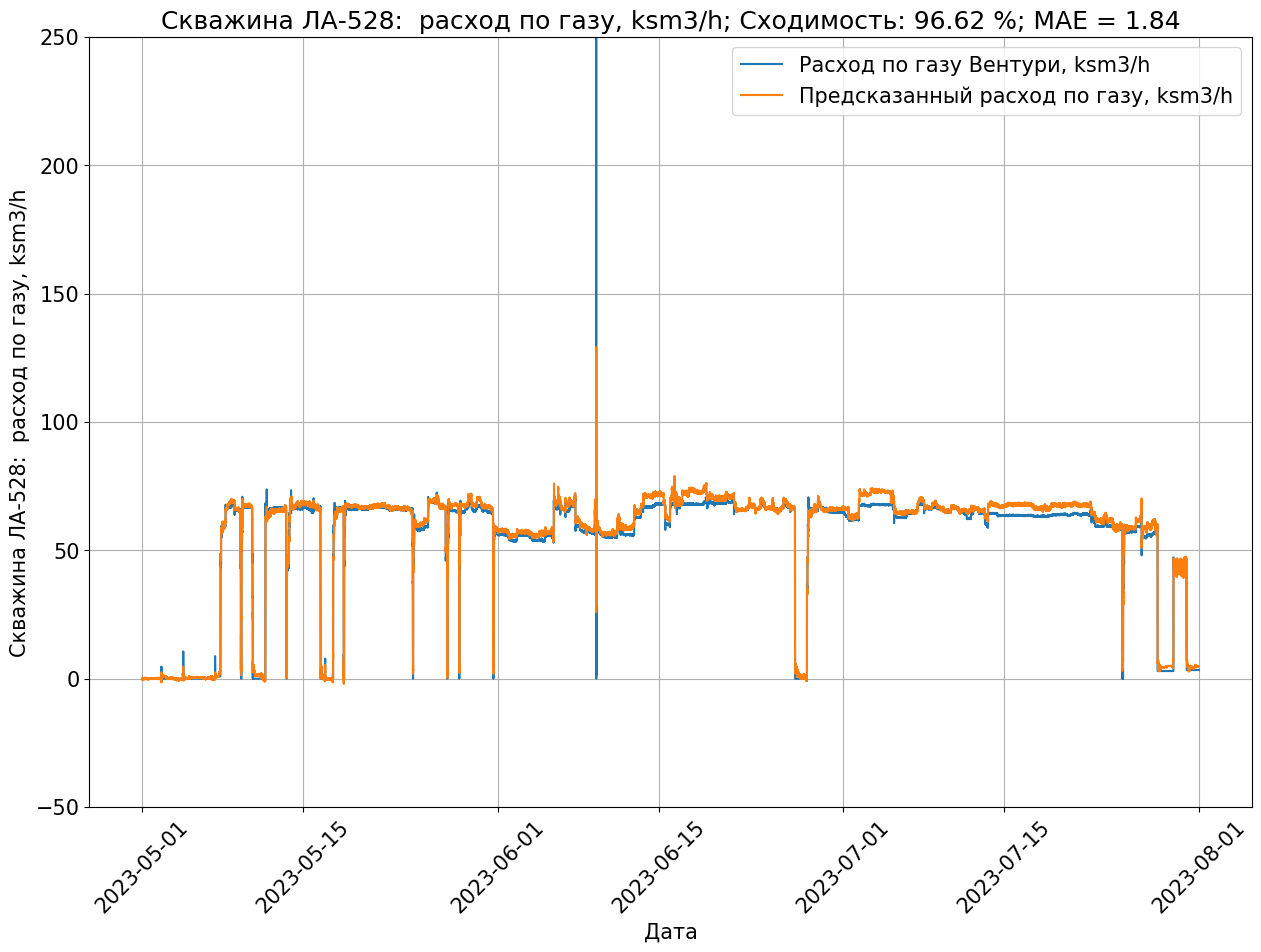

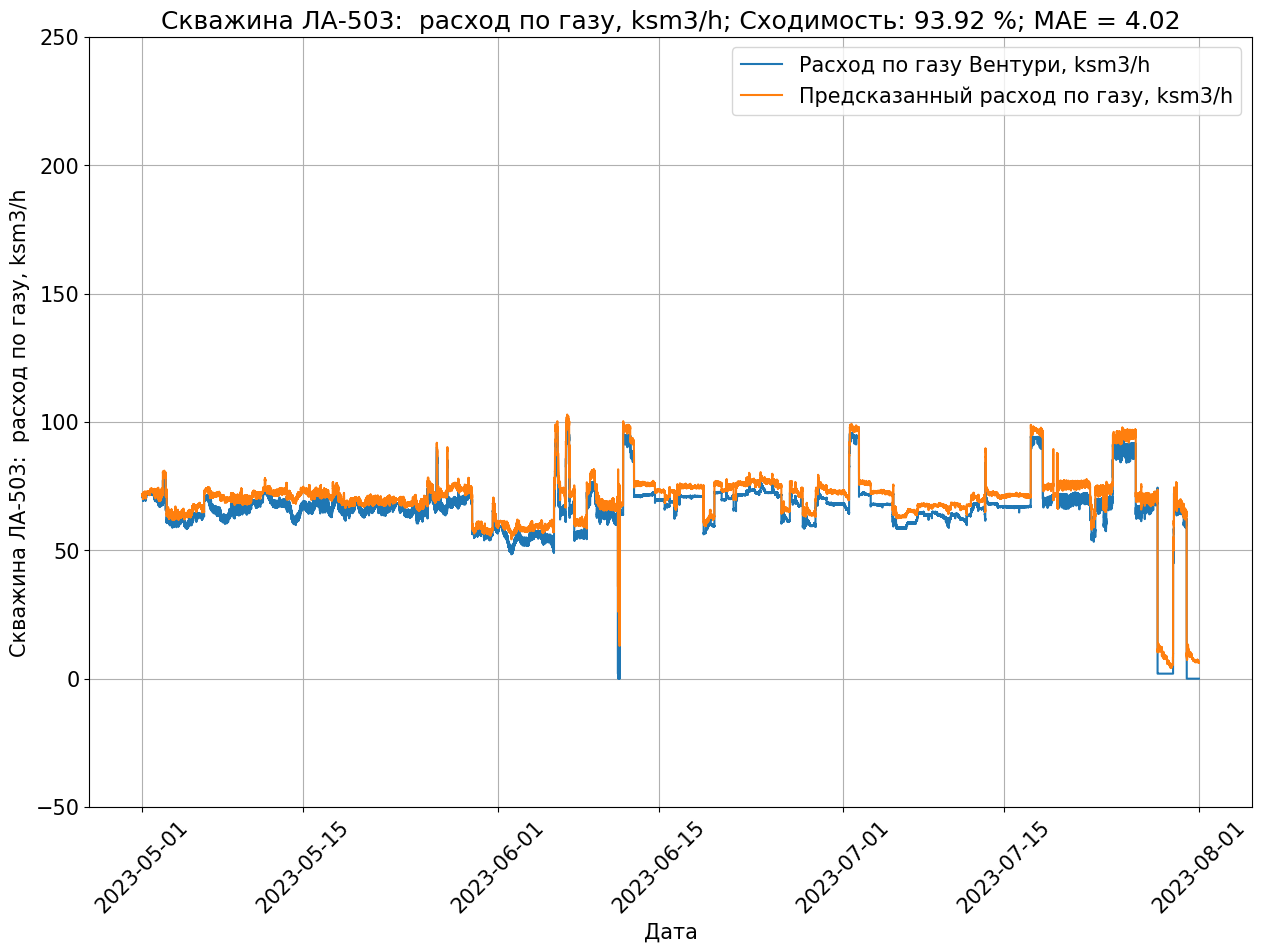

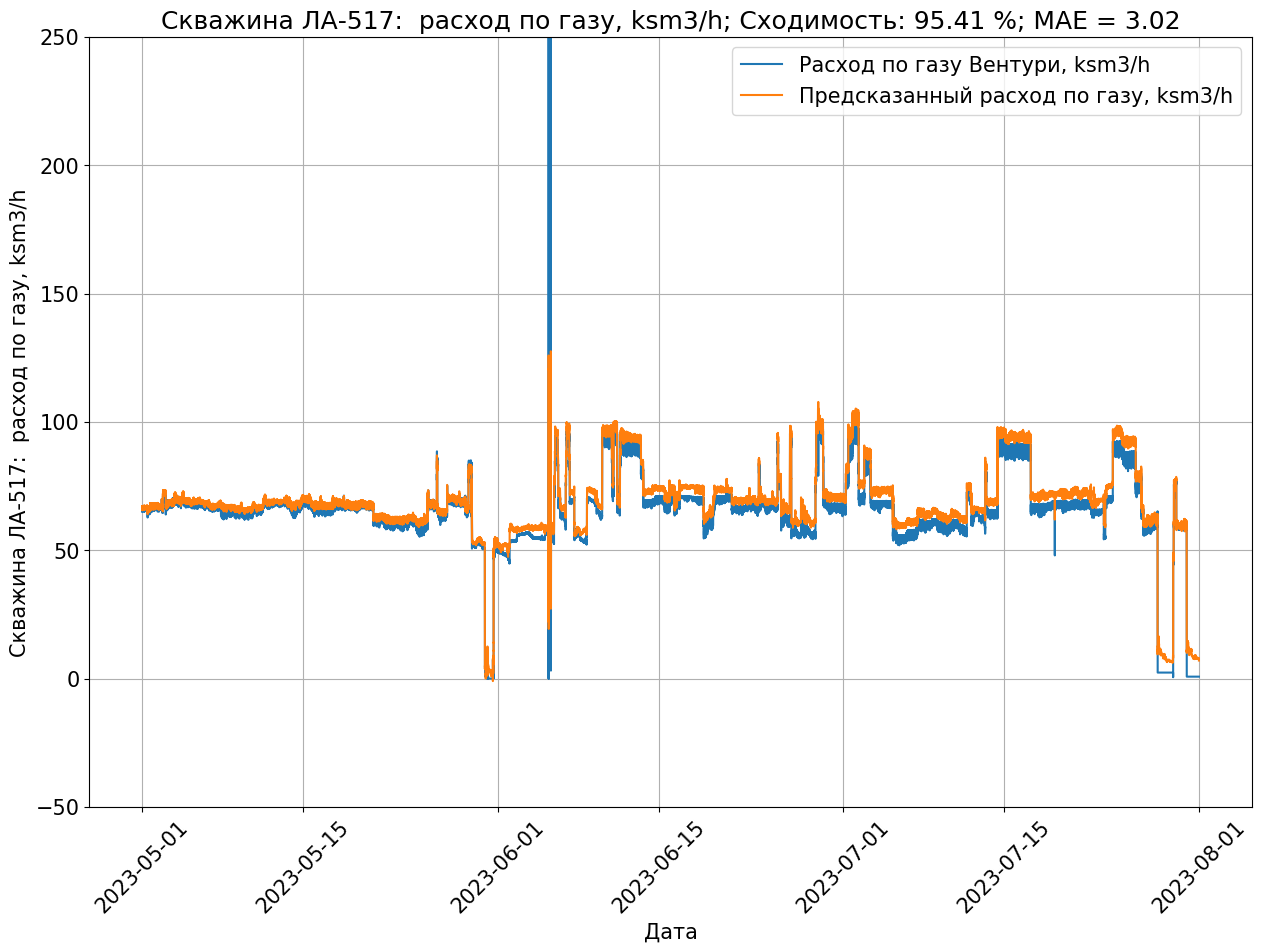

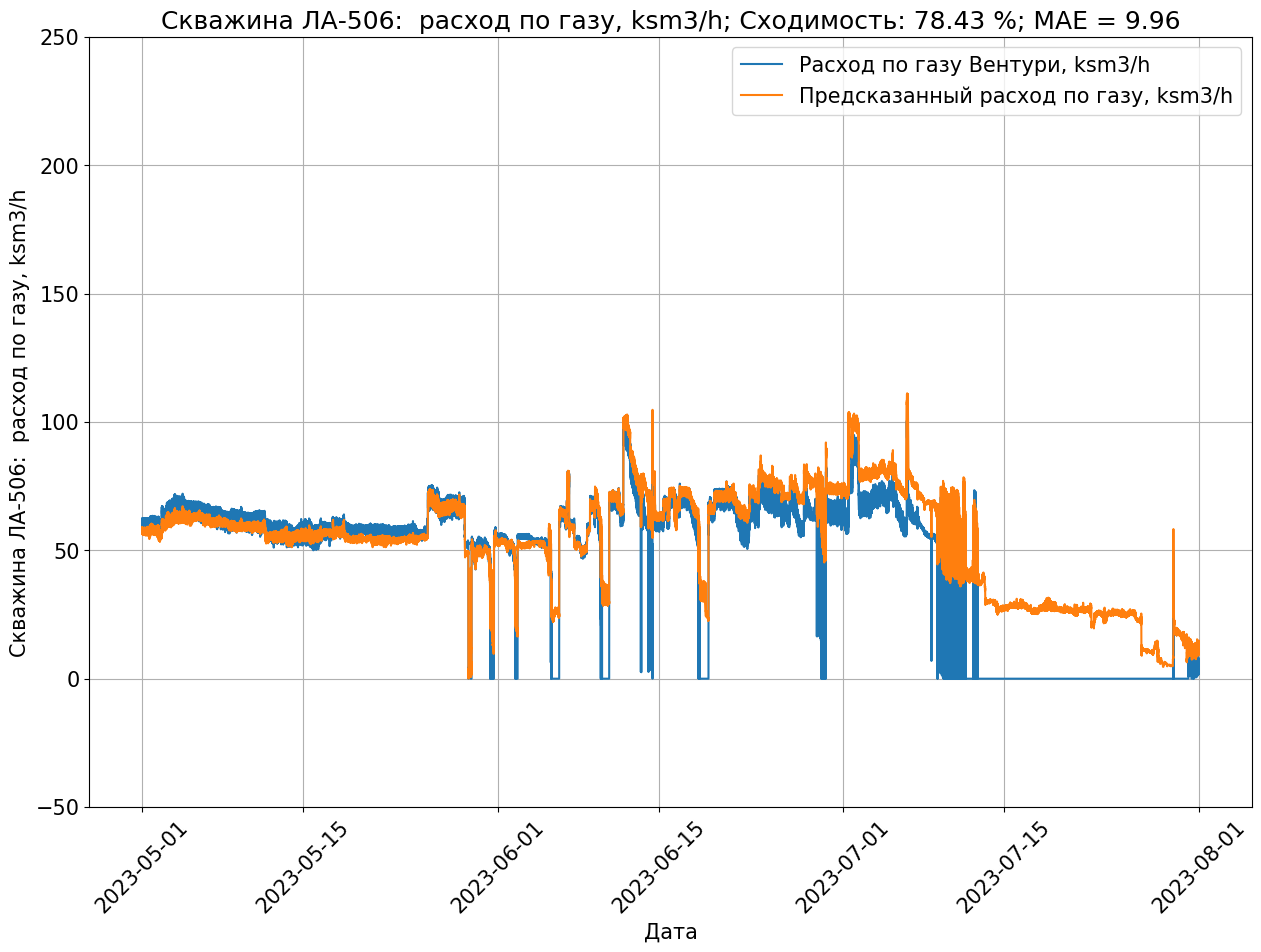

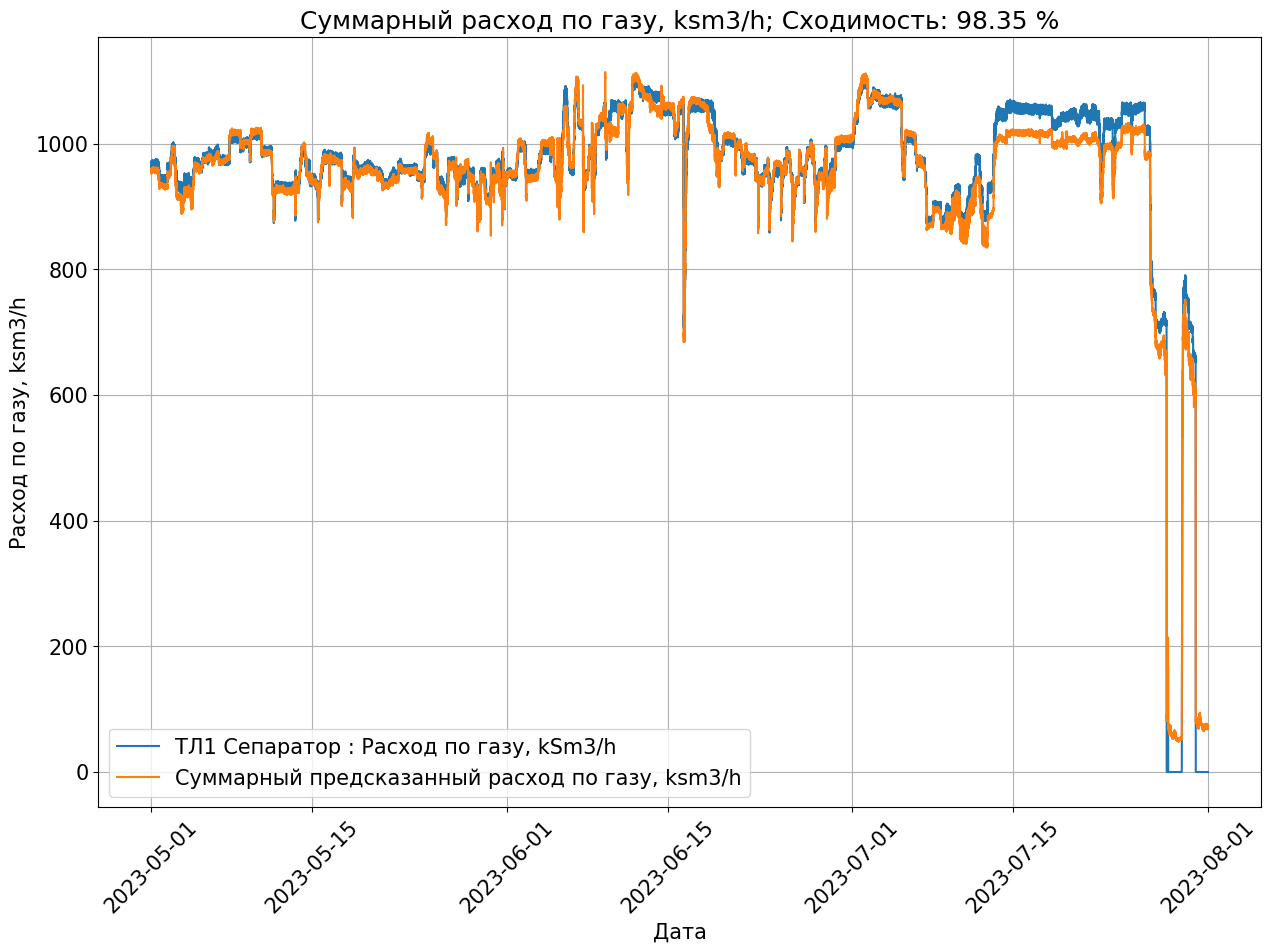

In [25]:
validation_visualize(df_modified_test, list_columns, xb)

**Данные ТЛ2 за период с 2023-08-02 по 2023-08-03**

Средняя сходимость по всем скважинам:  96.9 %
Минимальная сходимость:  92.1 %


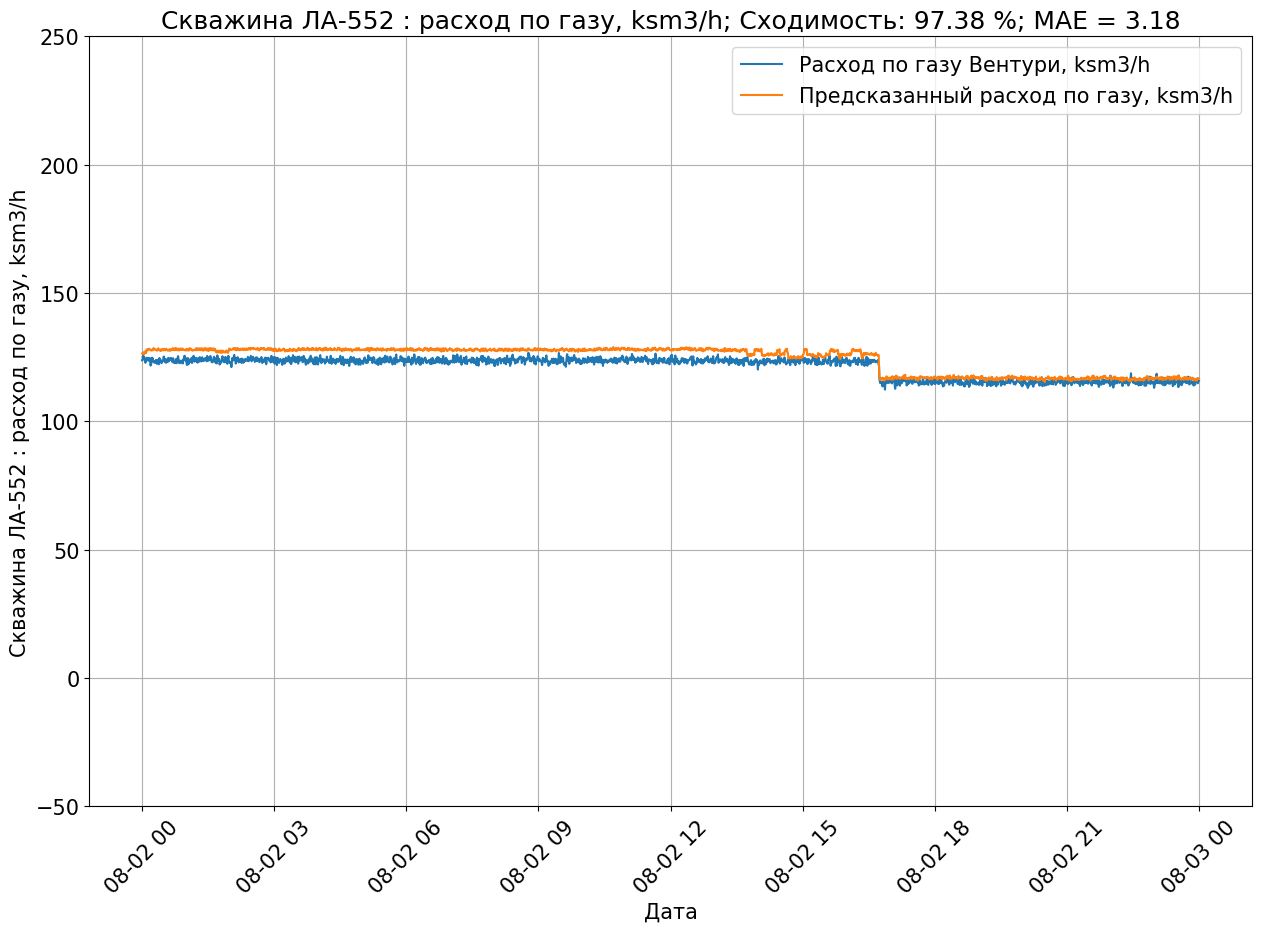

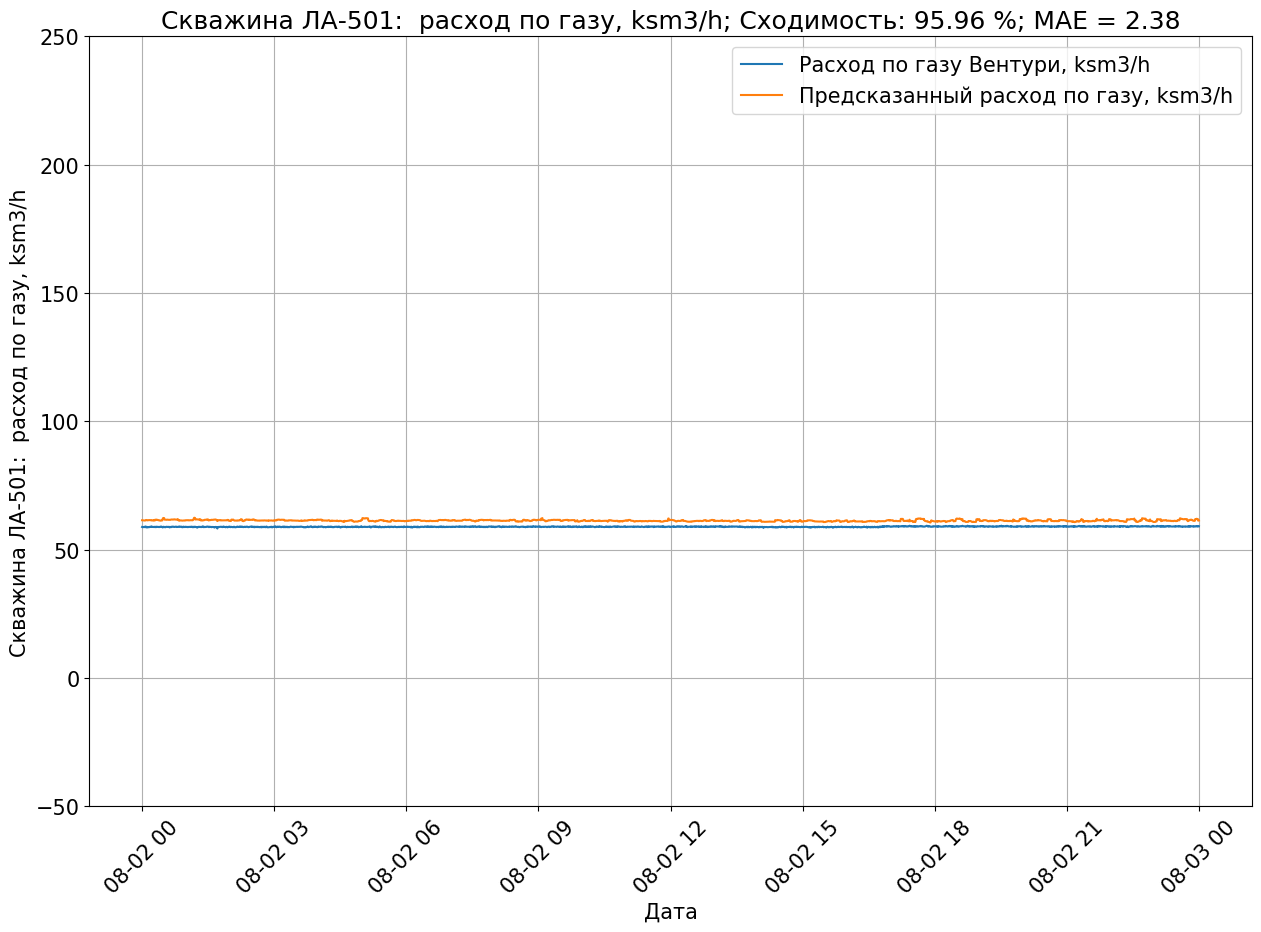

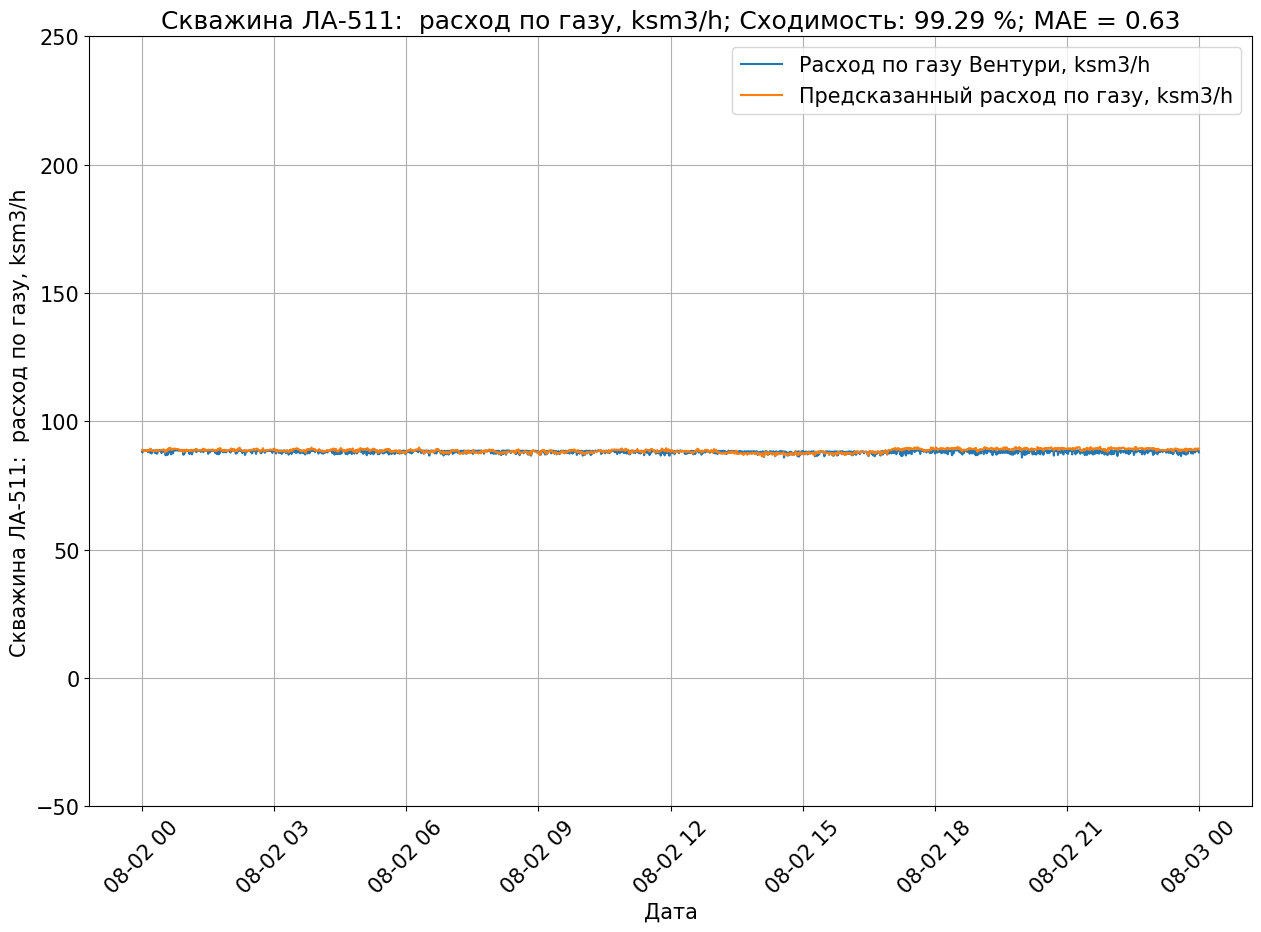

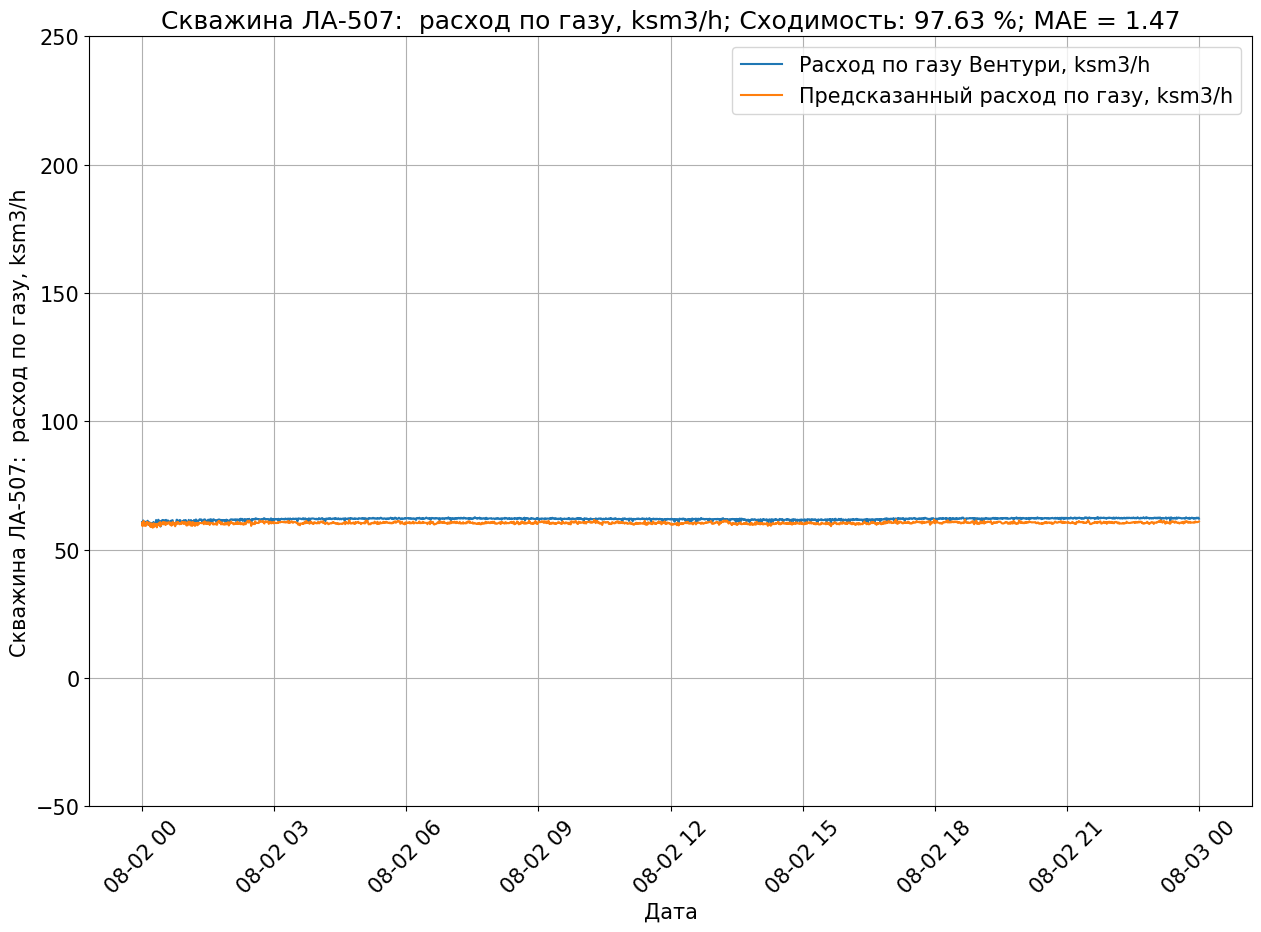

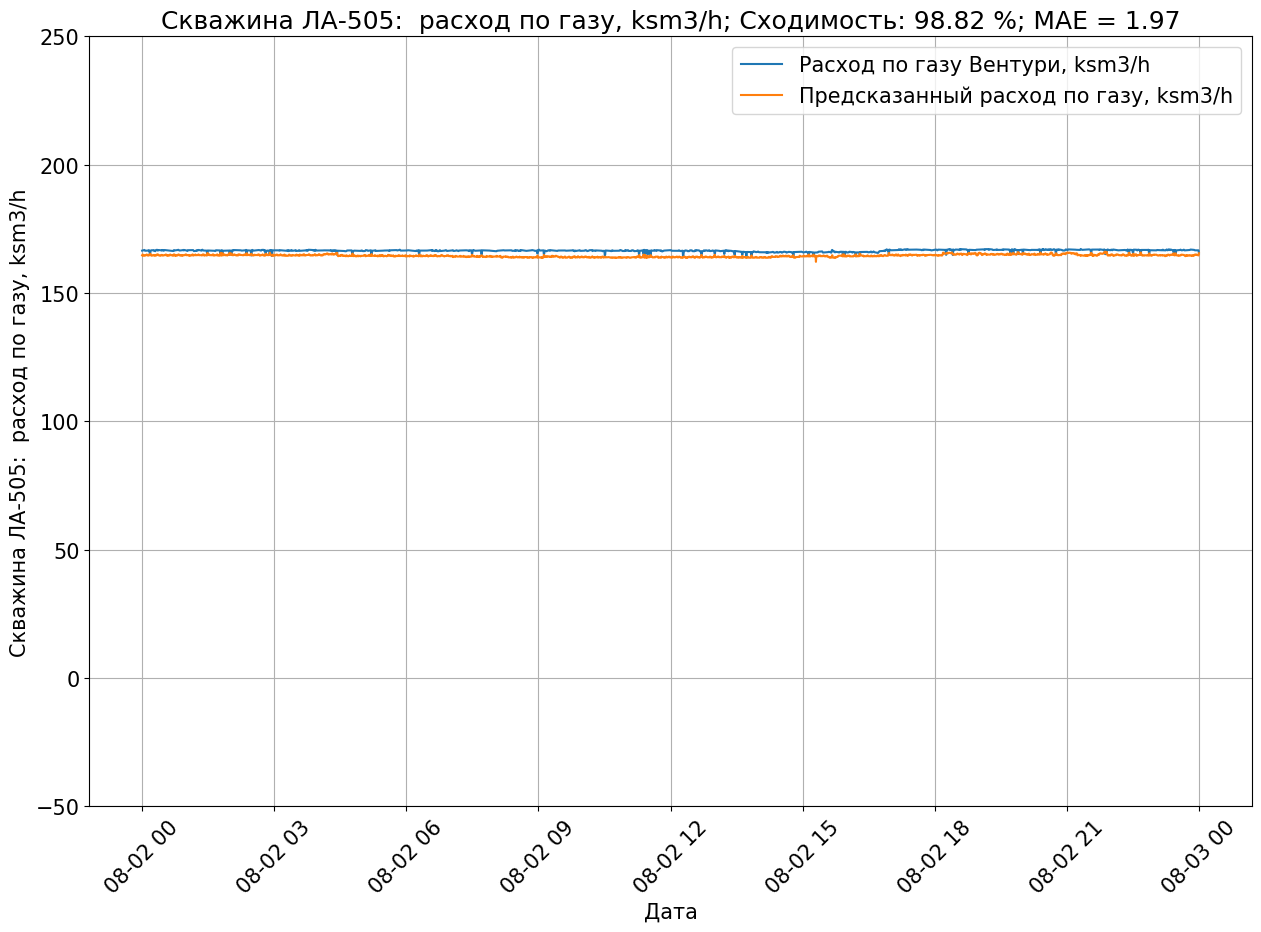

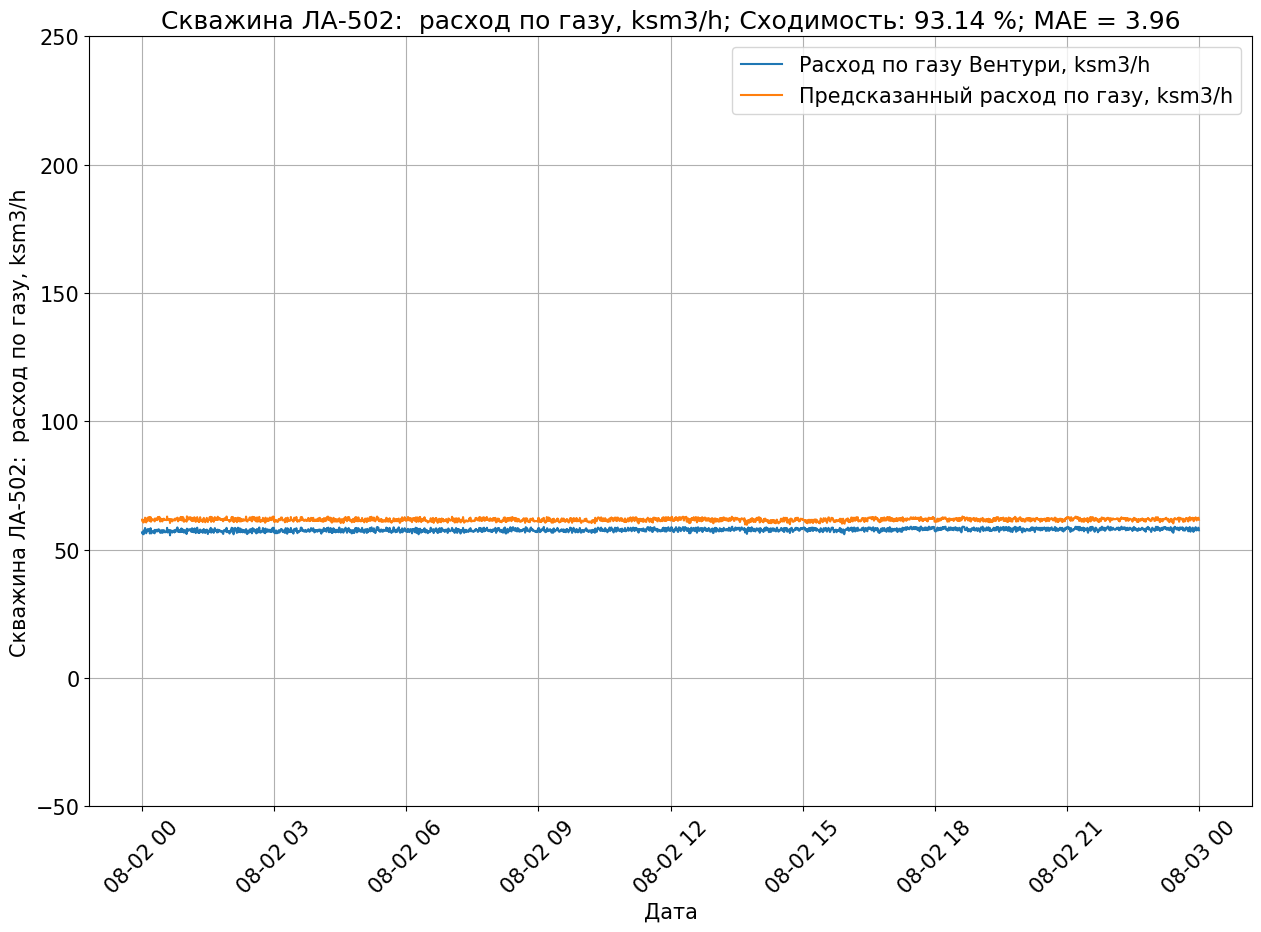

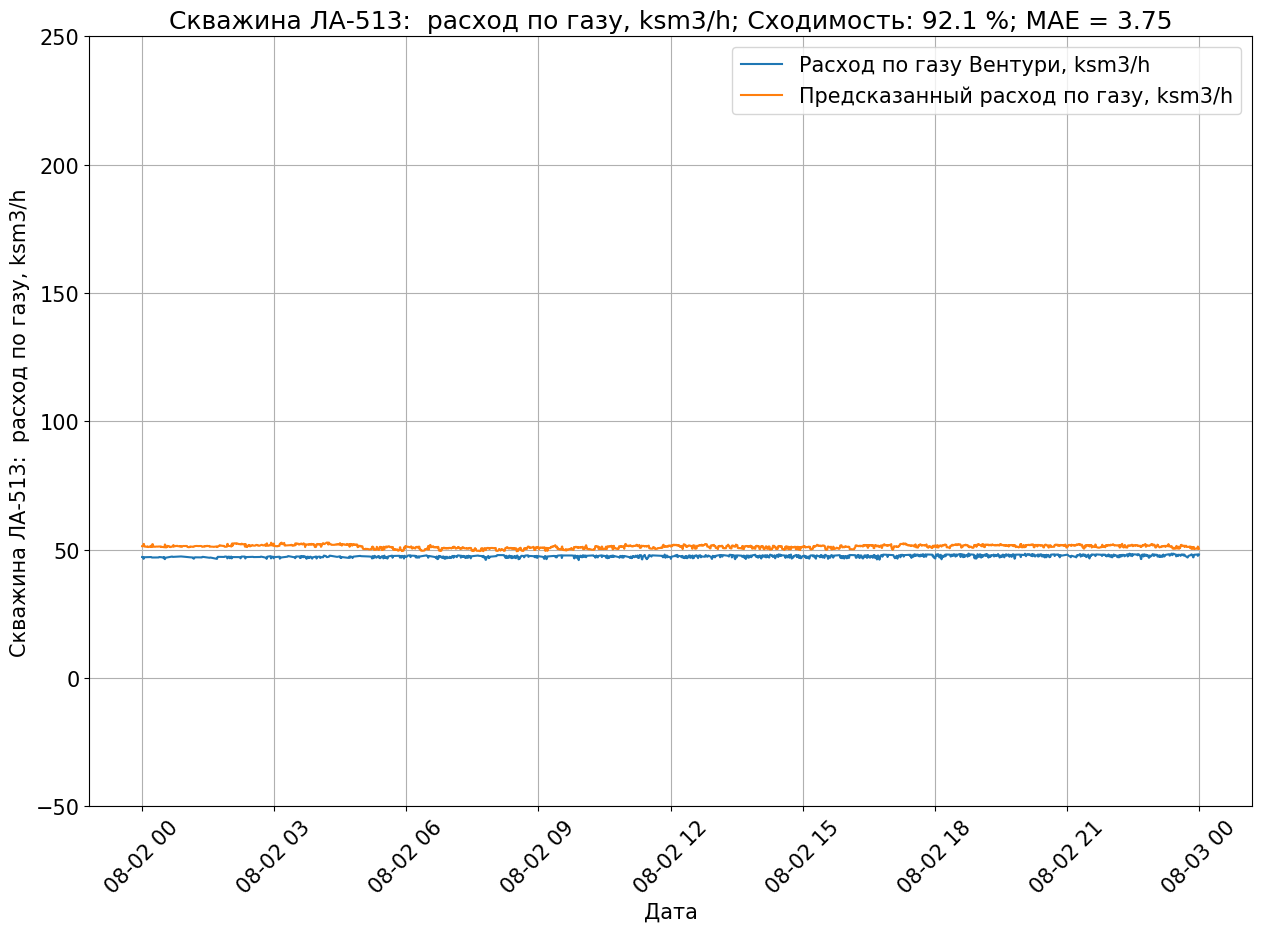

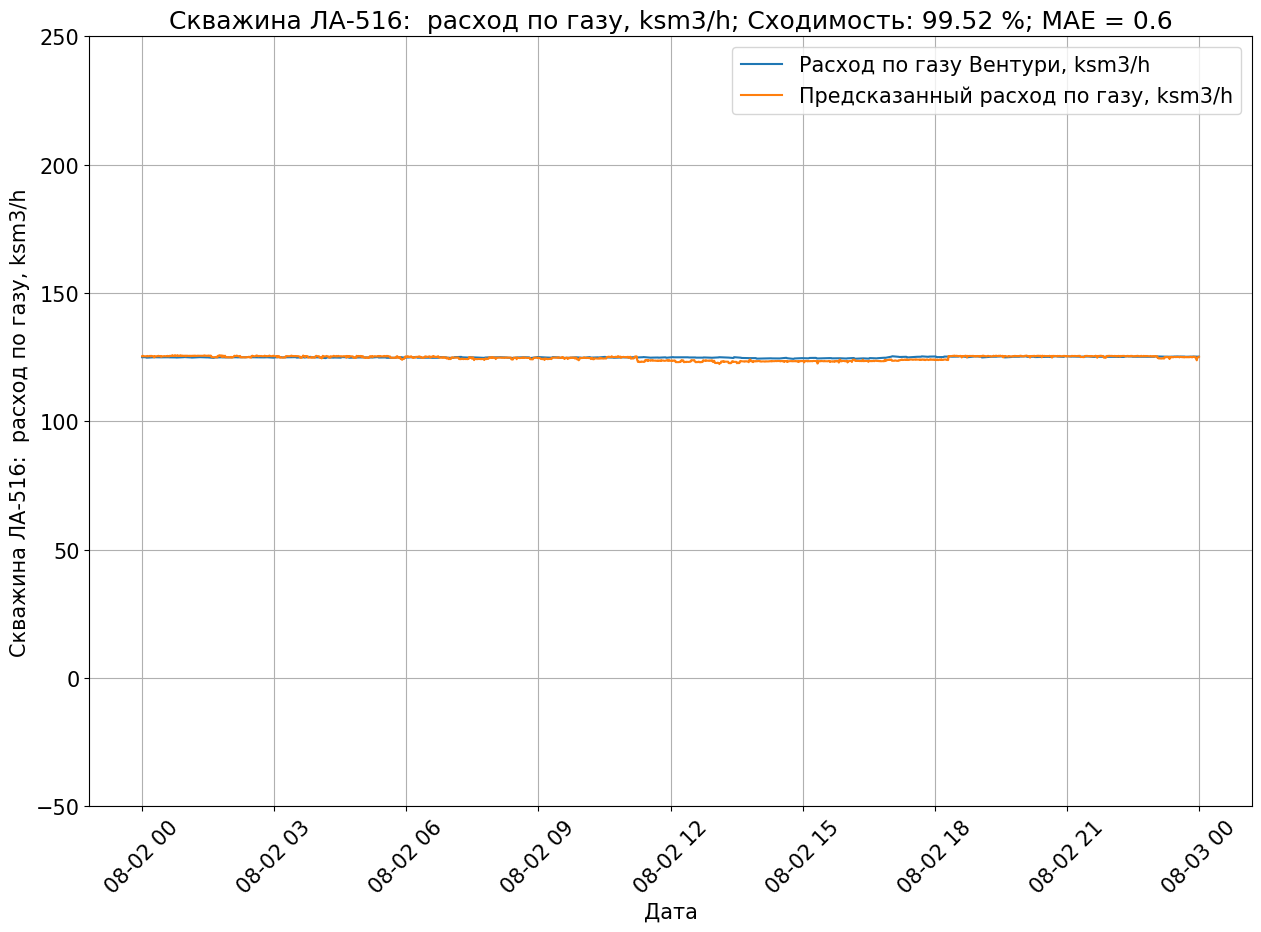

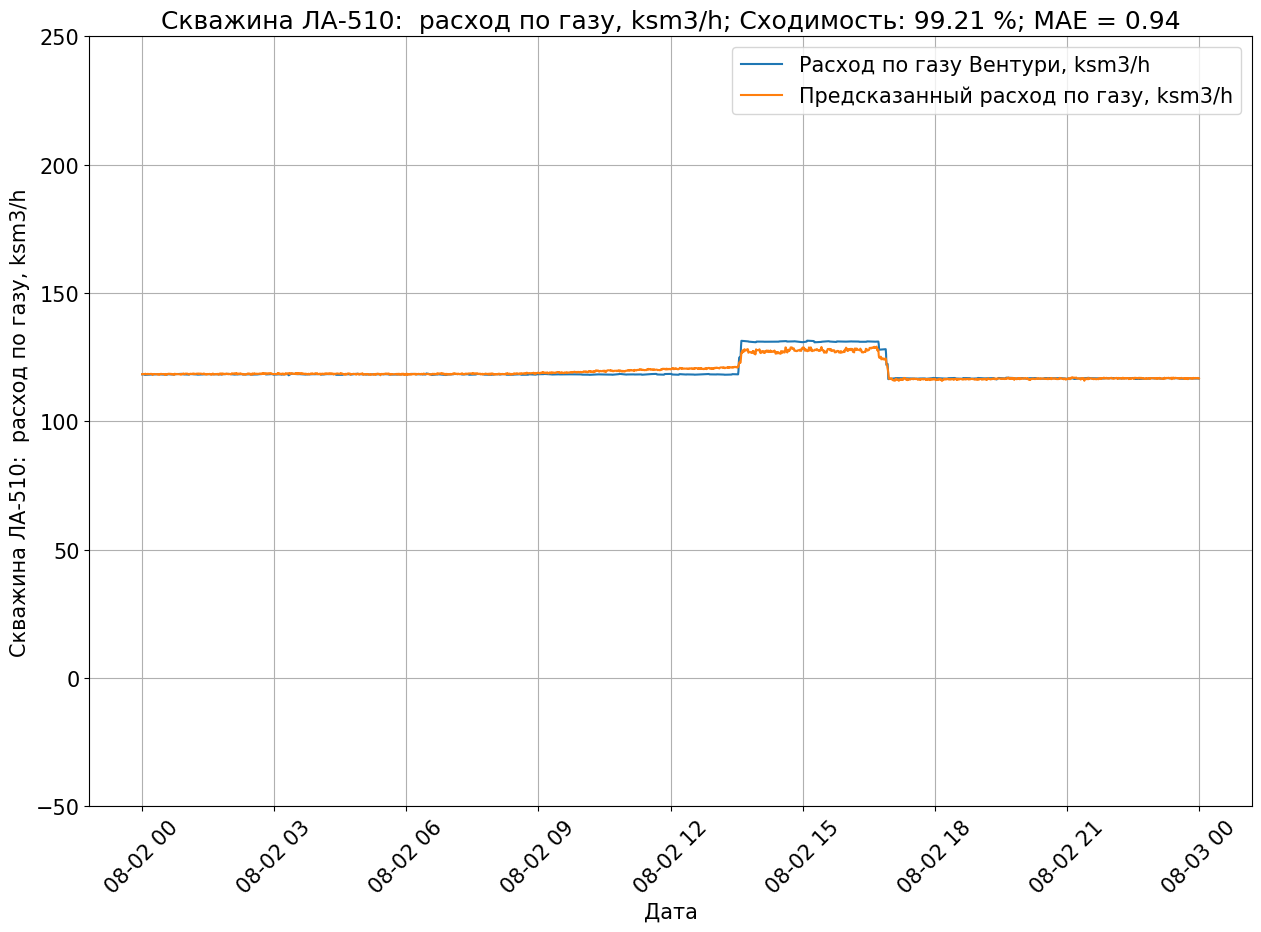

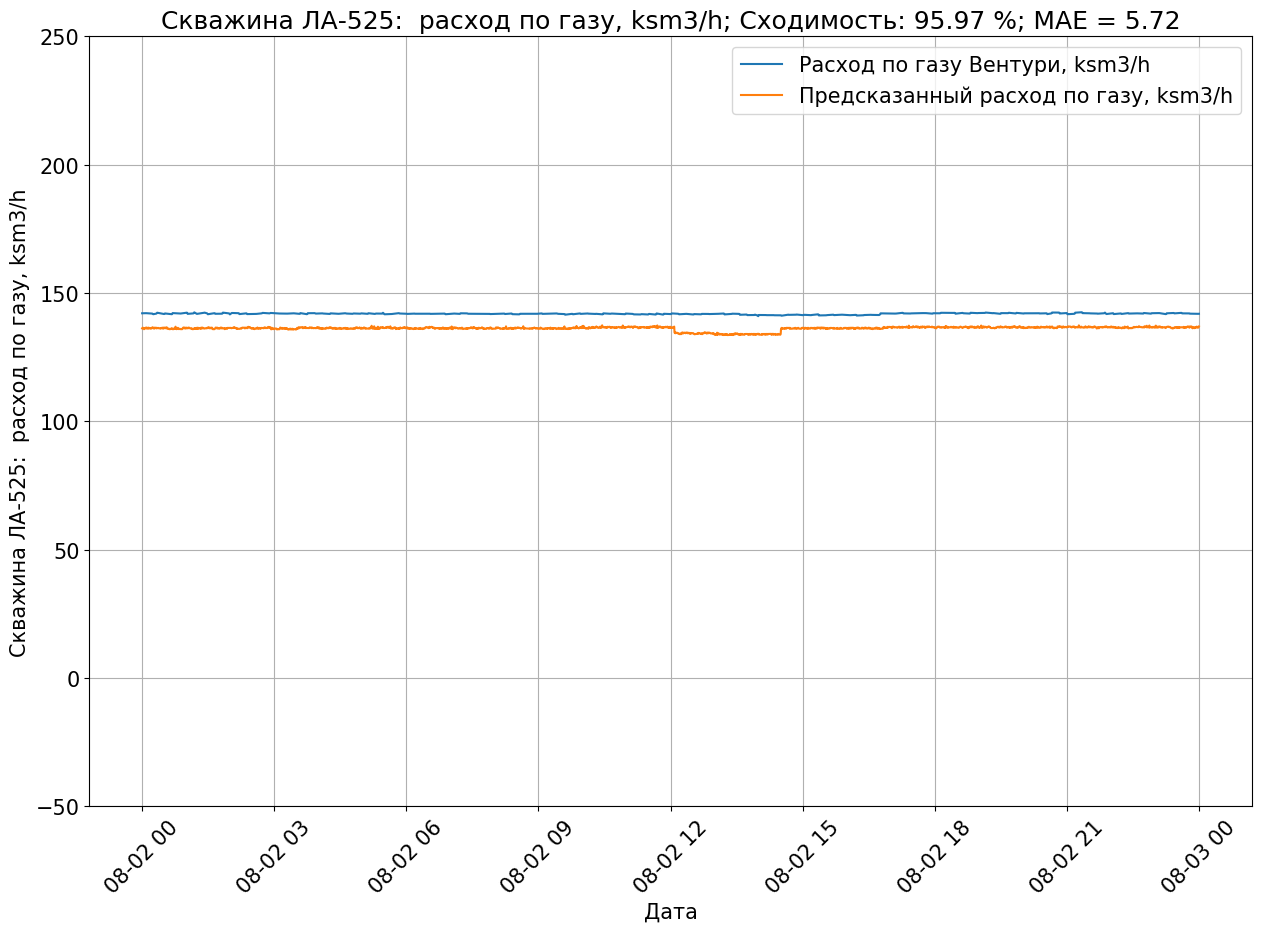

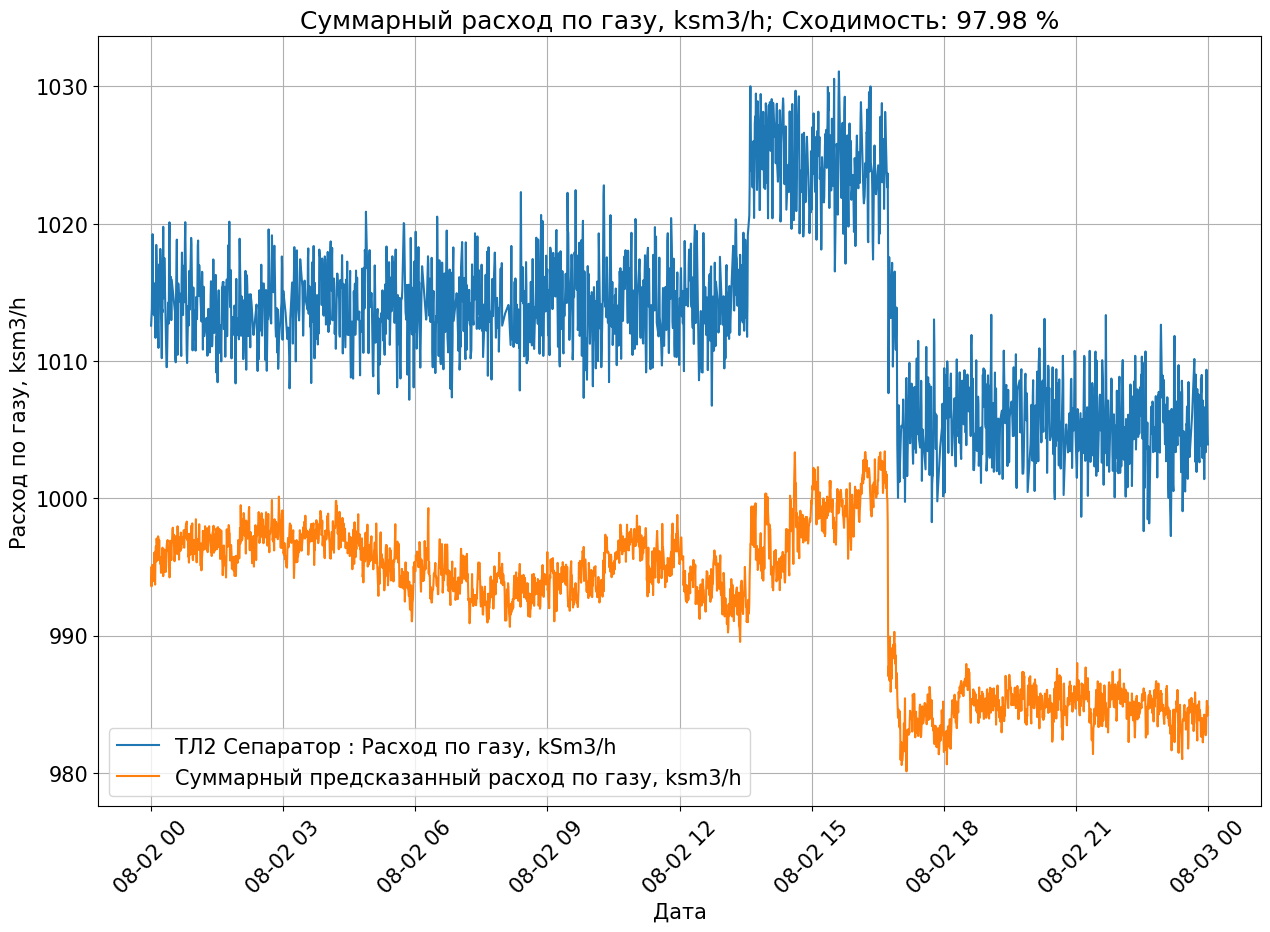

In [26]:
validation_visualize(df4_test, list_columns, xb)

**Данные ТЛ2 за период с 2023-08-01 по 2023-10-01**

Средняя сходимость по всем скважинам:  96.04 %
Минимальная сходимость:  91.79 %


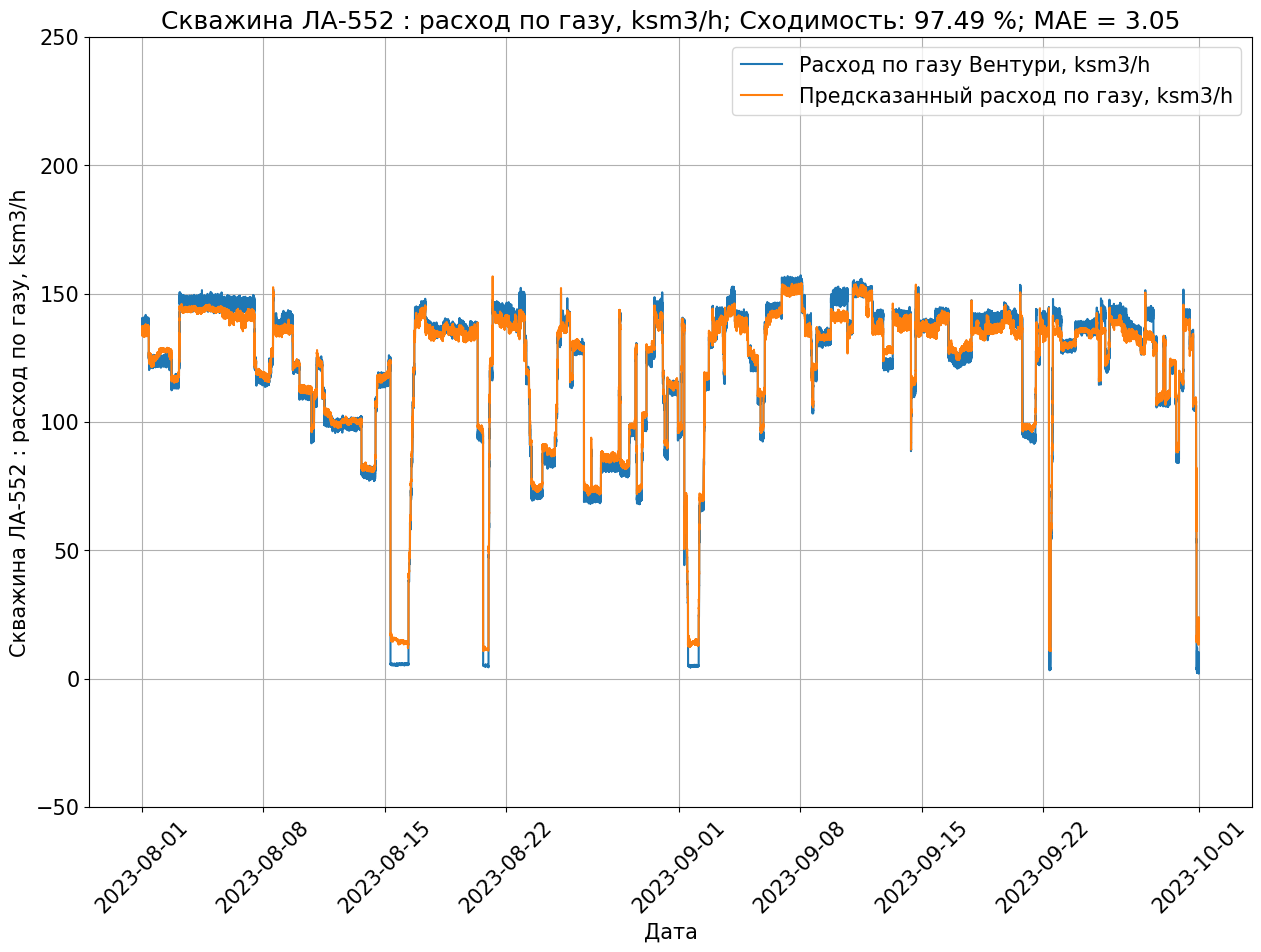

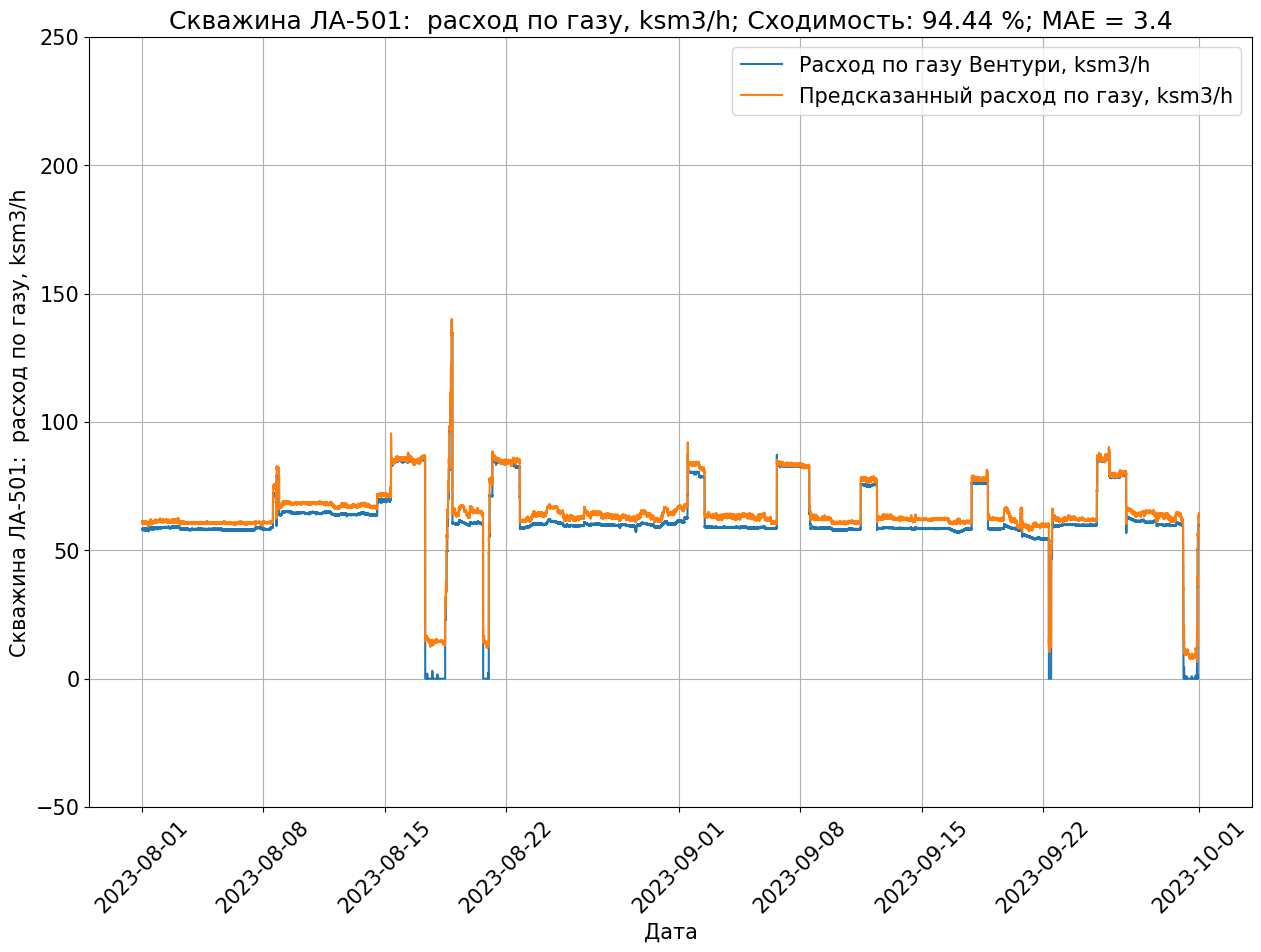

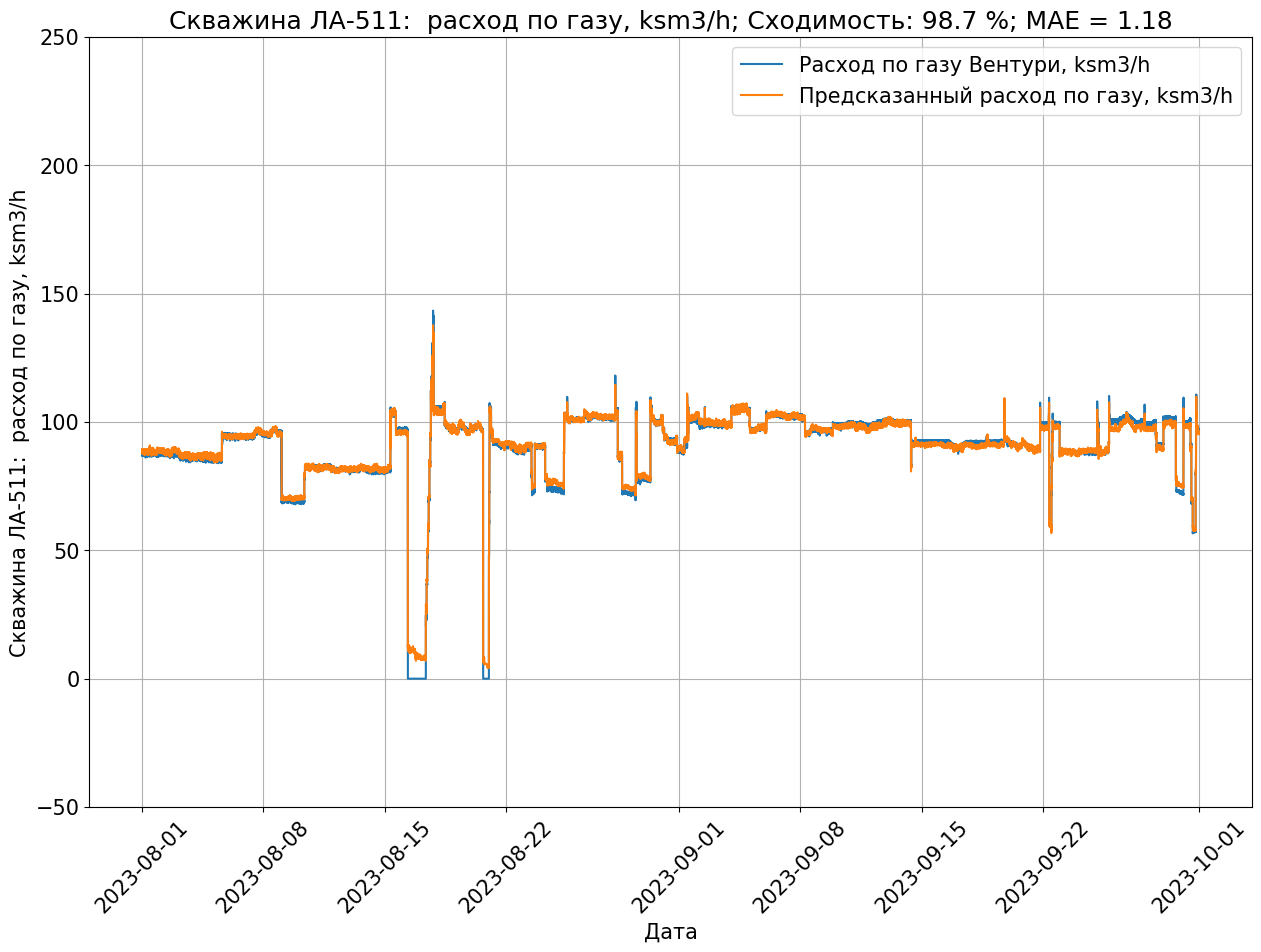

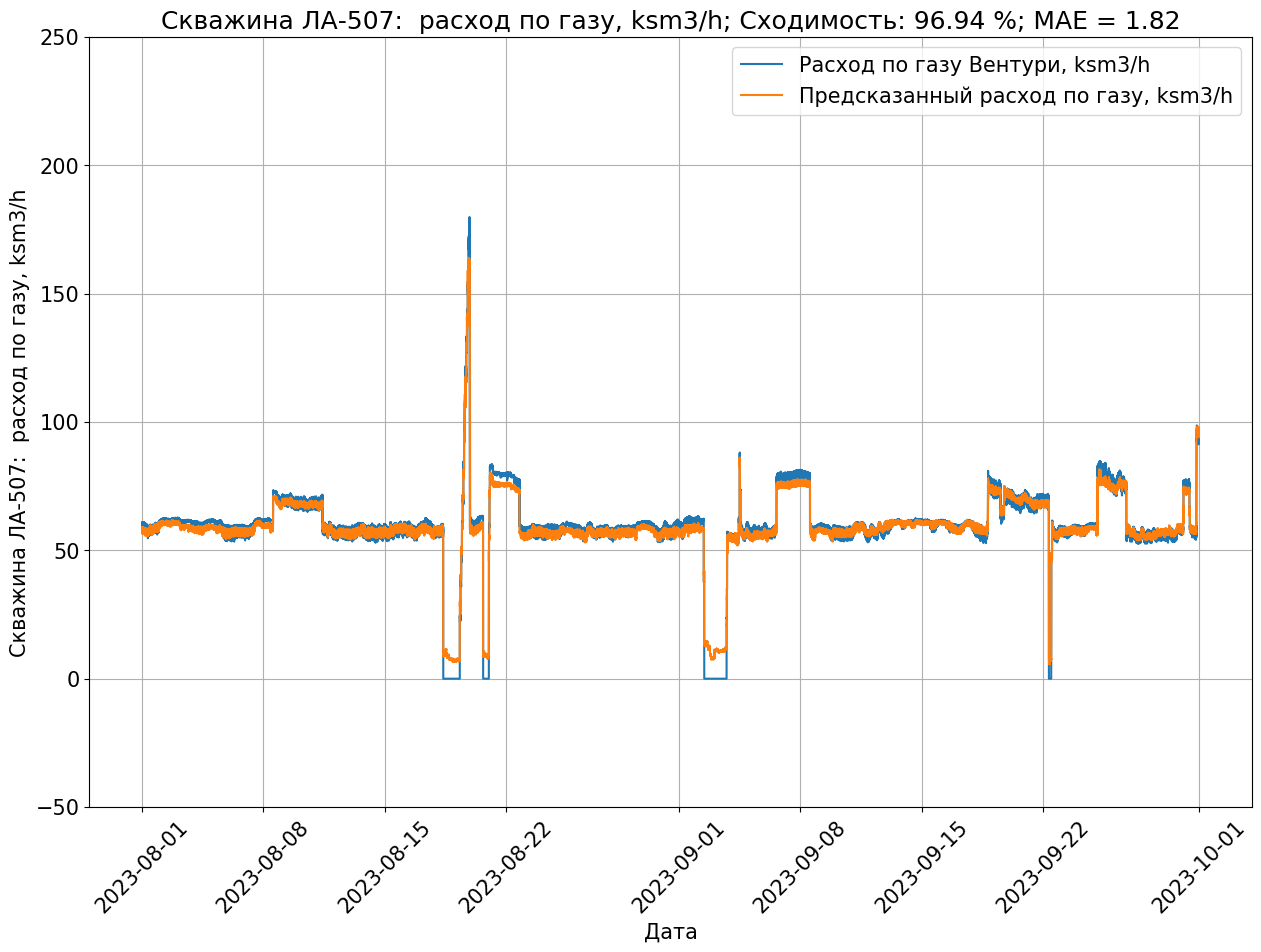

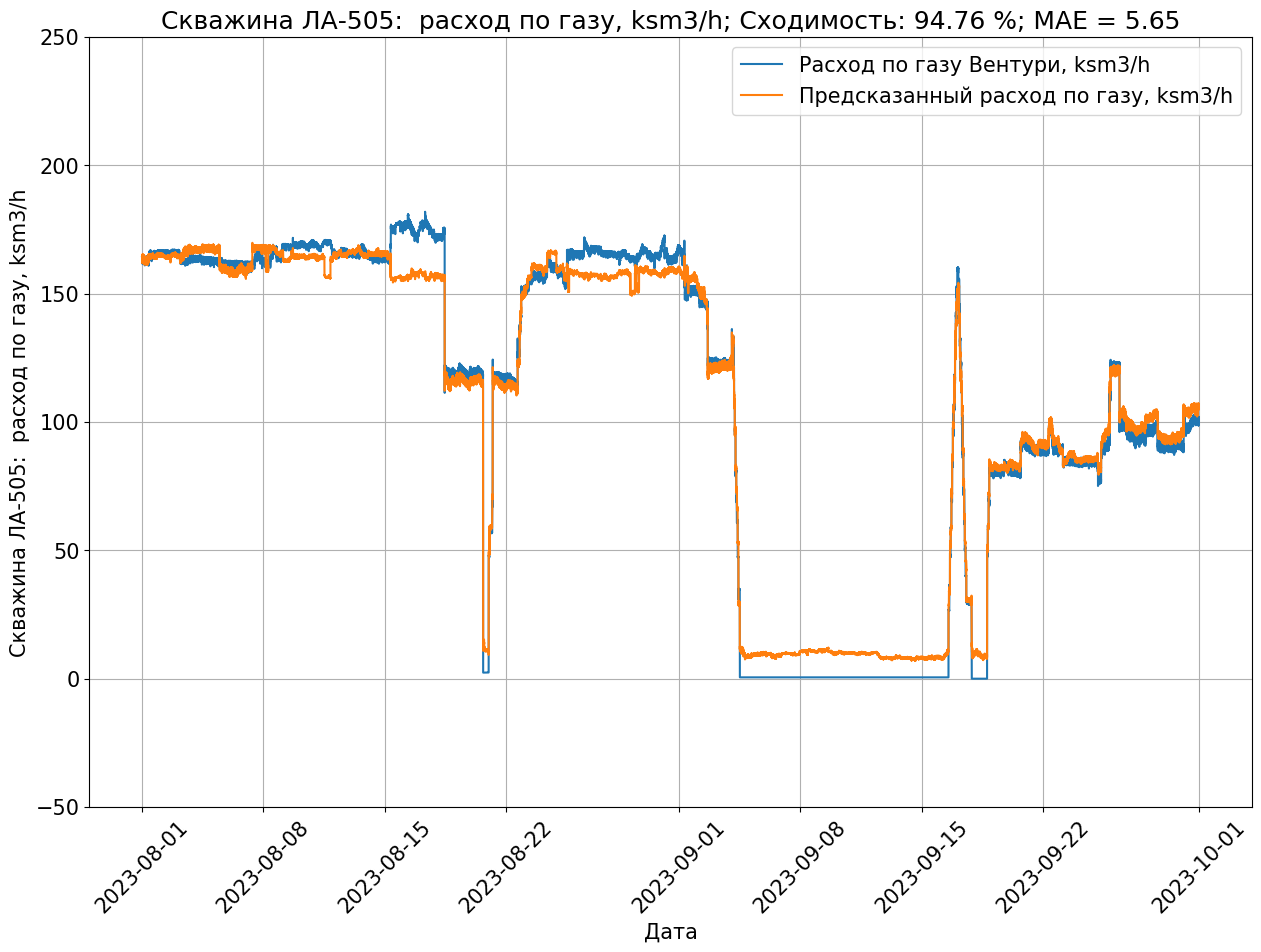

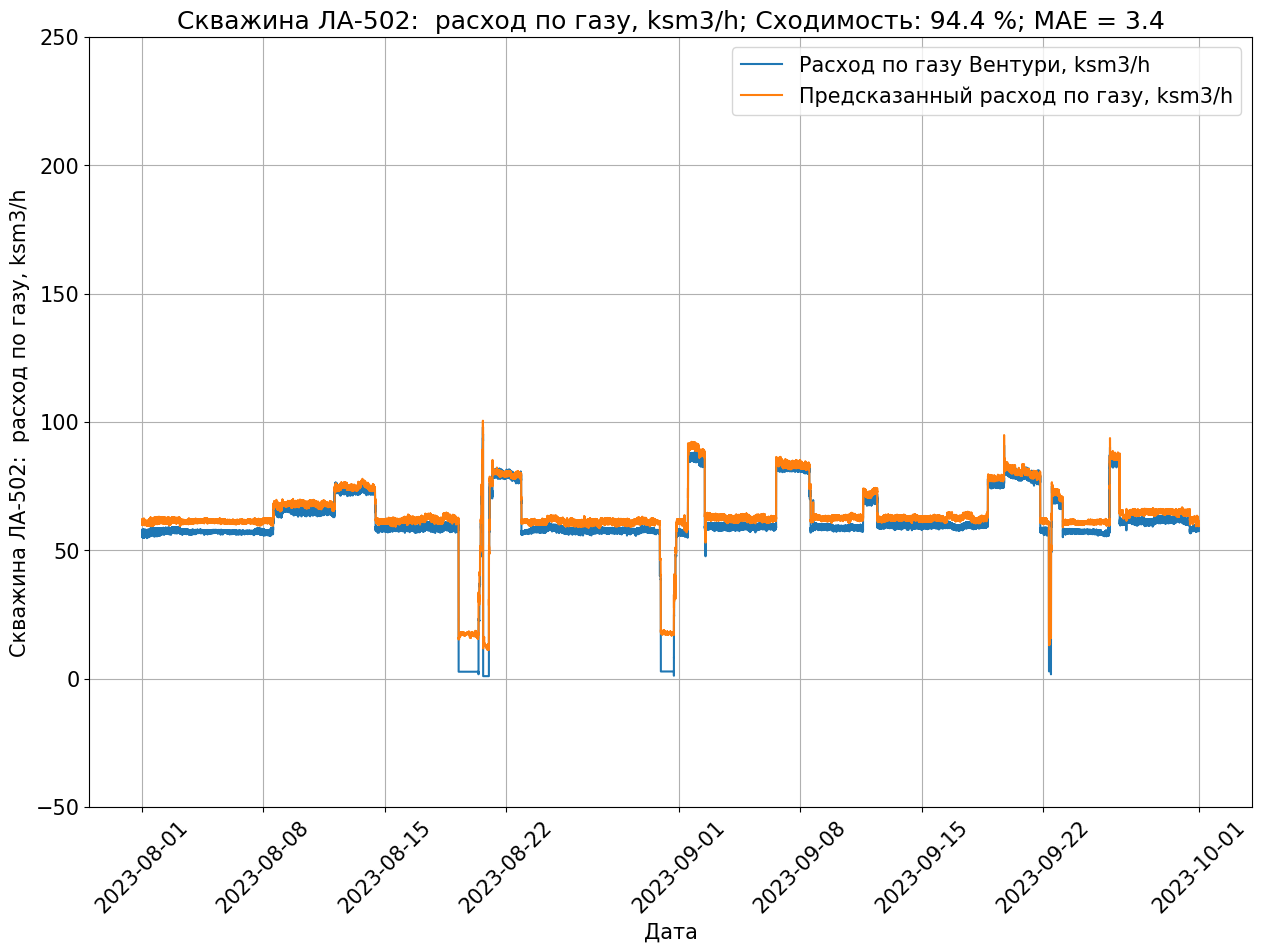

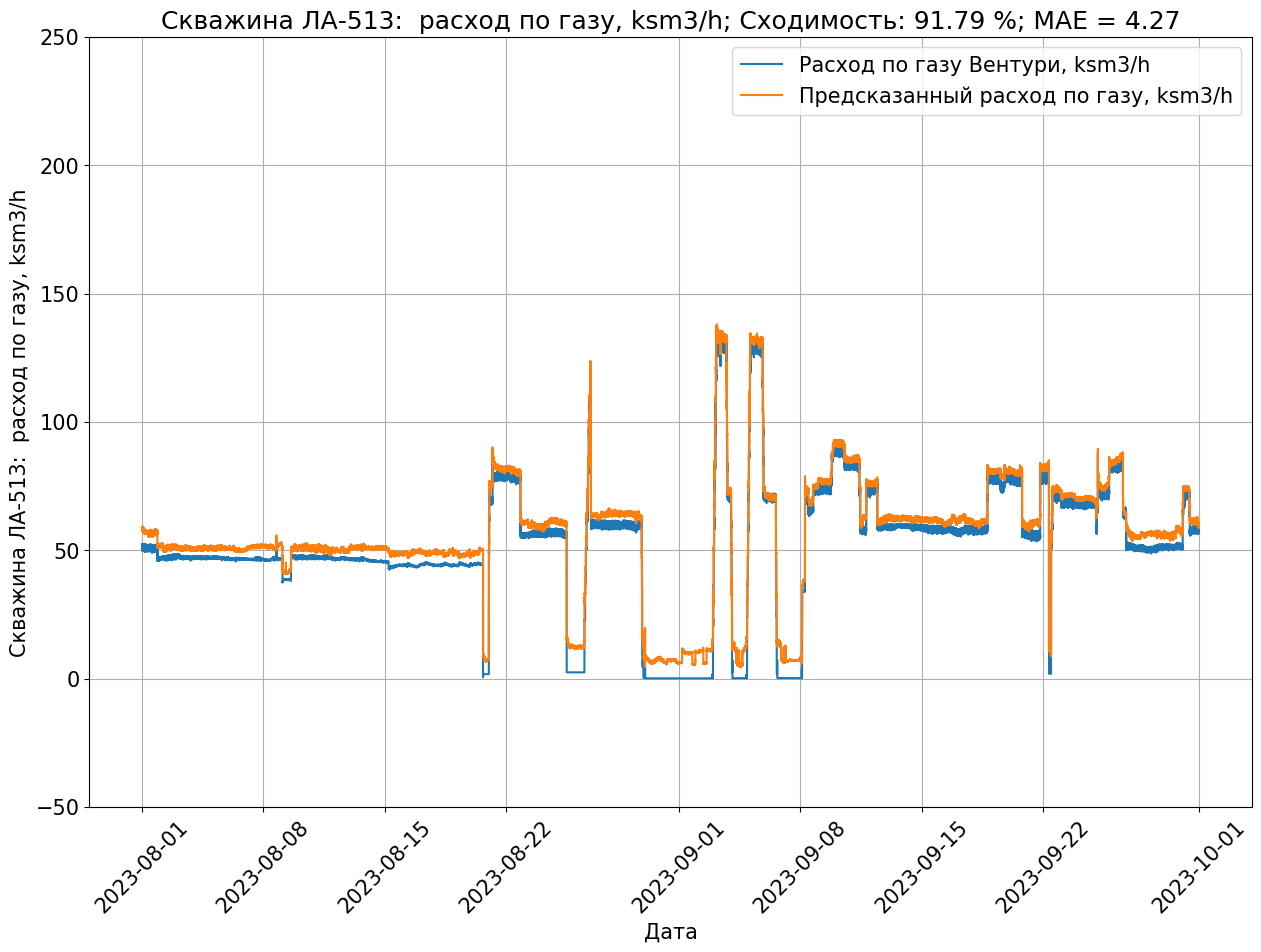

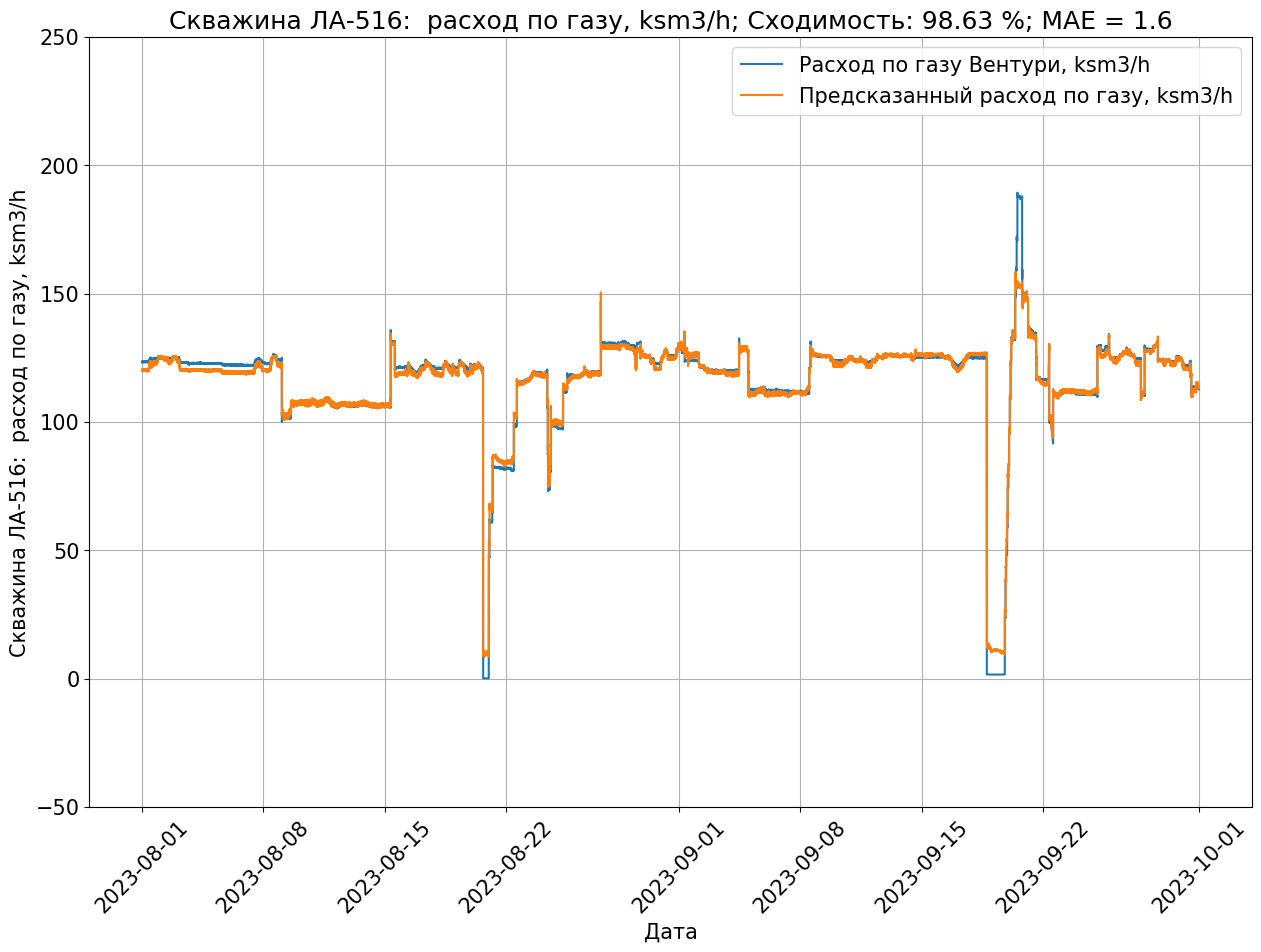

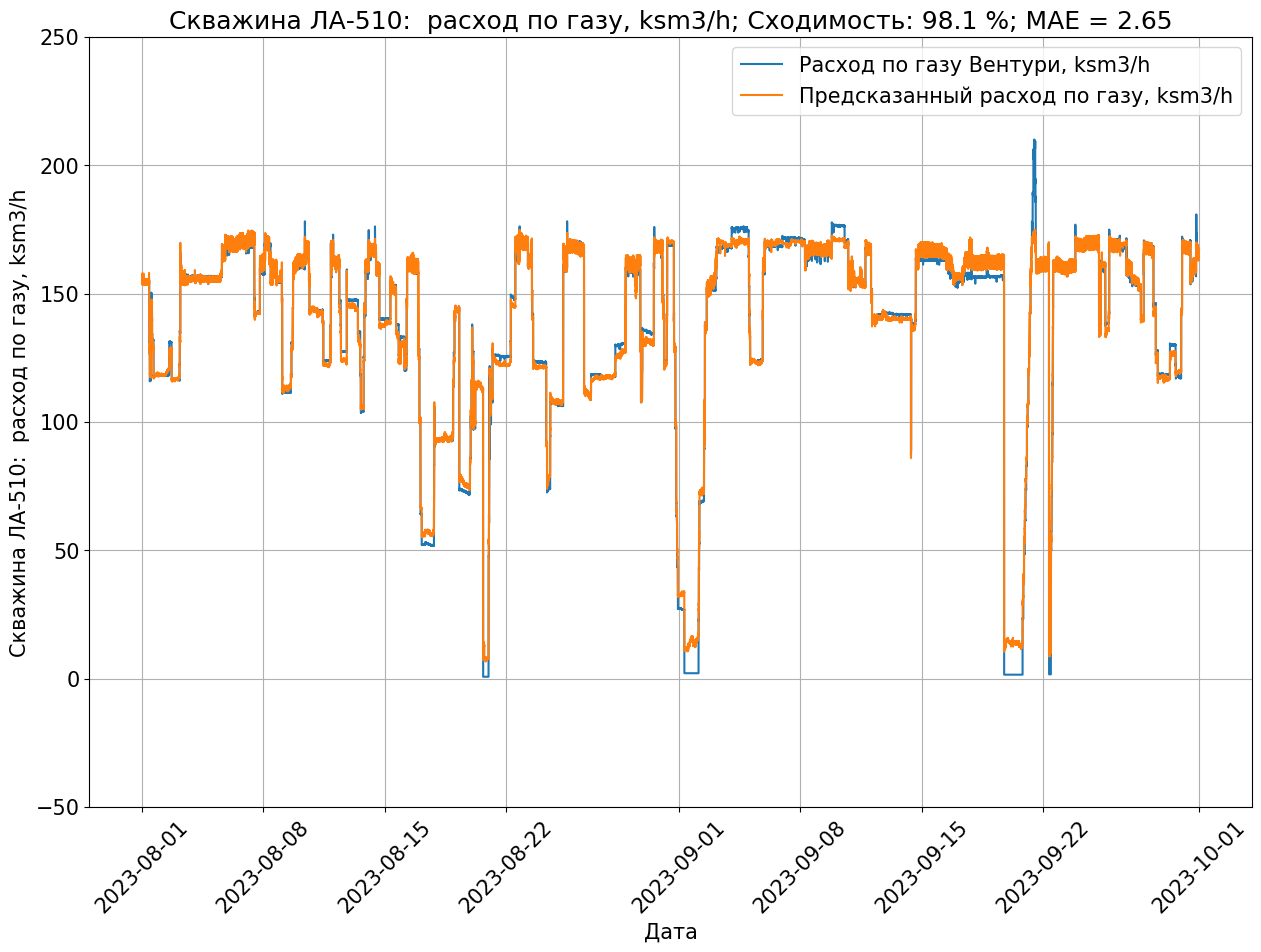

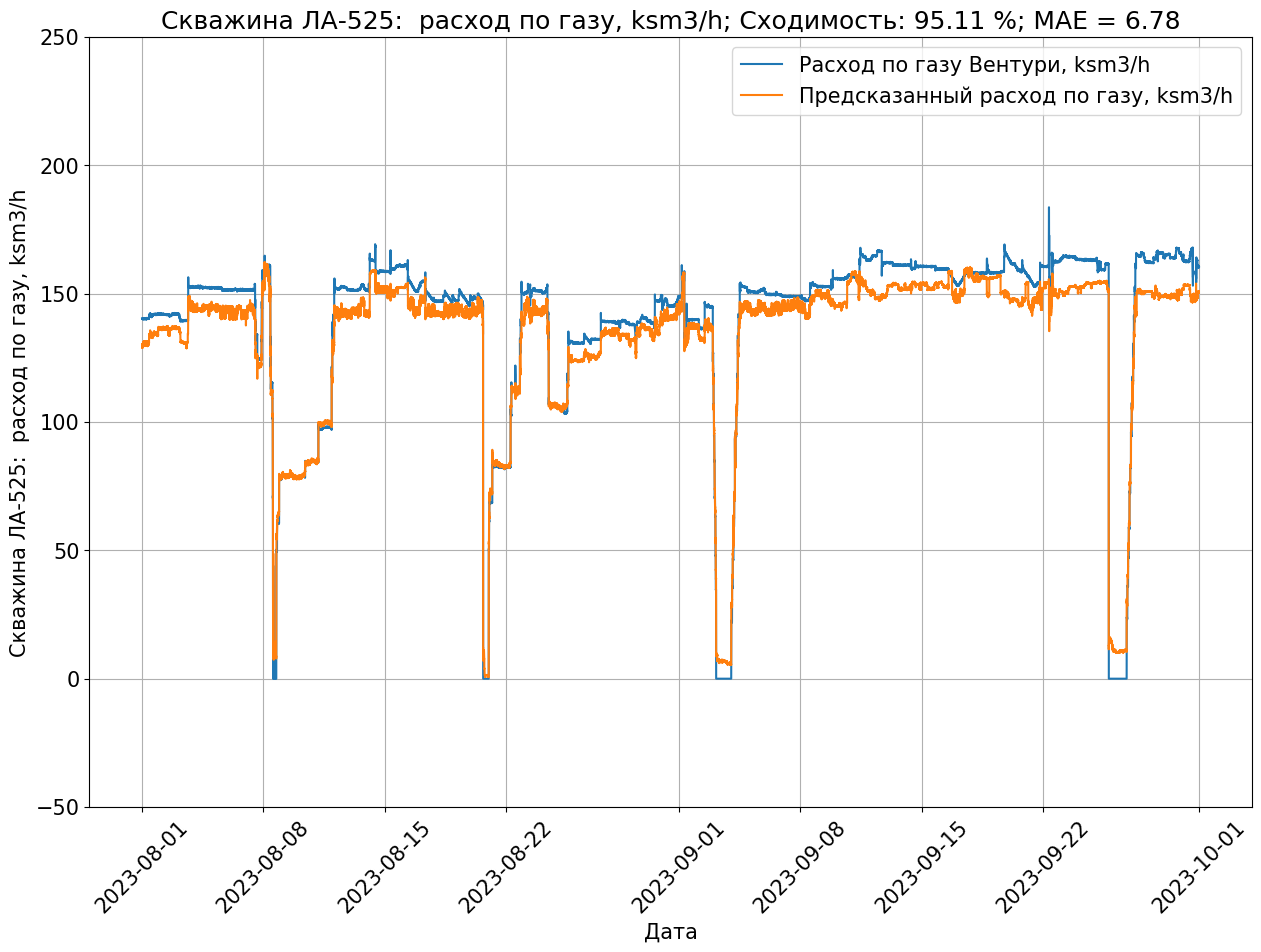

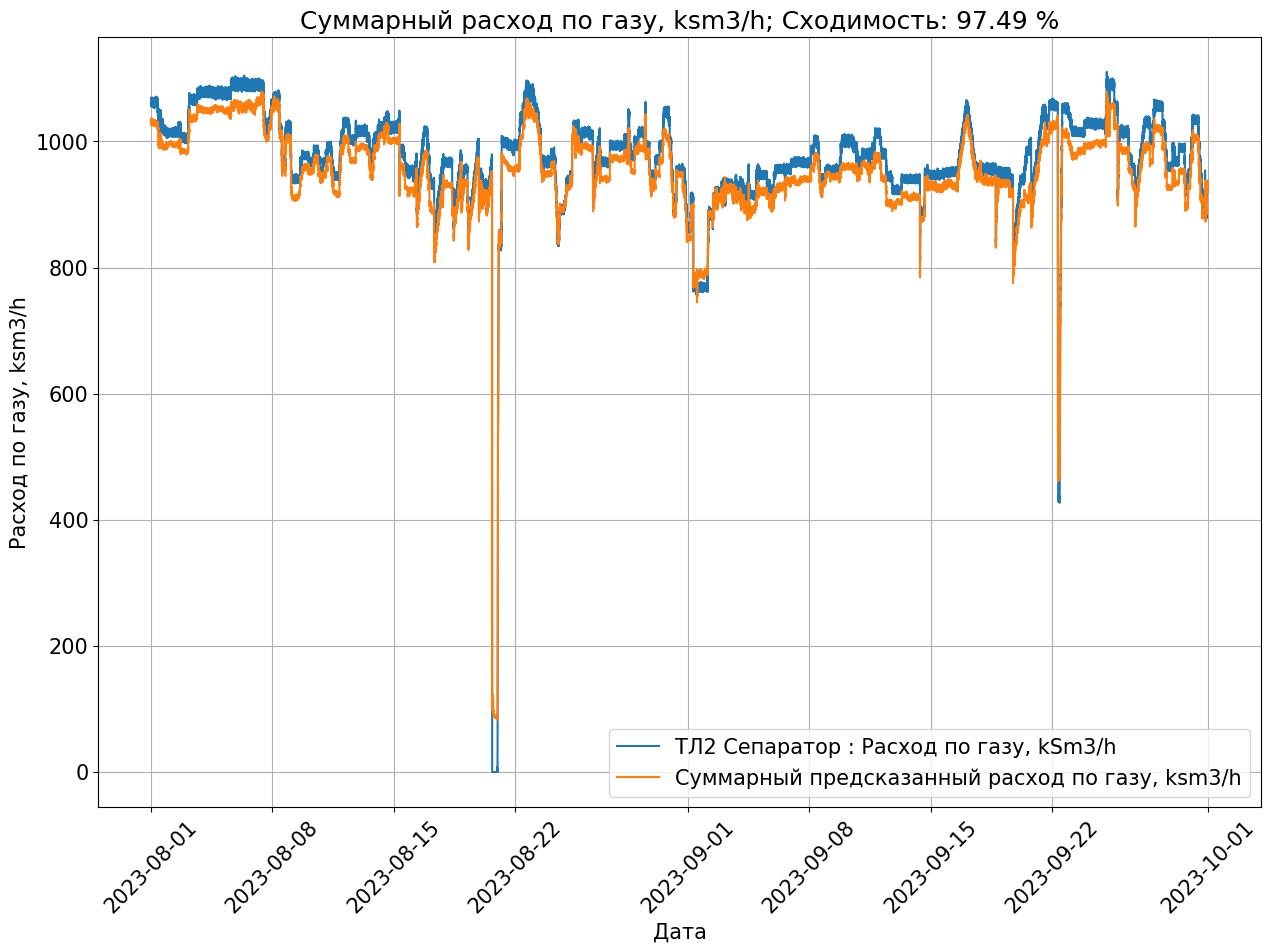

In [27]:
validation_visualize(df4, list_columns, xb)